## Contexto

Este trabajo tiene por objeto analizar algunas de las series que componen el Índice de Precios al Consumo (IPC), el cual es un indicador del nivel general de precios de la economía. Su variación a lo largo del tiempo es una aproximación de la variación en el costo de vida, y su control es uno de los objetivos de la política macroeconómica y monetaria de los países.

En Uruguay, la serie de precios se inició en el año 1914 a partir de estudios sobre las condiciones de vida de los individuos, pero no fue hasta 1963 que se produjo el primer índice elaborado a partir de la información de una encuesta de gastos del consumo de los hogares. Desde entonces, los sucesivos cambios de base tienen por objetivo actualizar la composición y estructura de la canasta de consumo, con el fin de reflejar de la mejor manera posible los verdaderos niveles de gastos de la población. El último cambio de base (Octubre 2022) establece una nueva canasta de referencia, la cual se construyó en base a la Encuesta de Gastos e Ingresos de los Hogares (ENGIH) realizada entre los meses de Noviembre de 2016 y Octubre de 2017.

En cuanto a la composición del IPC, éste se divide en dos grandes grupos:

1. Bienes Transables: Son todos aquellos bienes que pueden ser exportables y/o importables. Las siguientes son las series que lo componen y su peso relativo:
  * Alimentos y bebidas no alcohólicas (25.85 %)
  * Bebidas alcohólicas, tabaco y narcóticos (3.64 %)
  * Ropa y Calzado (2.91 %)
  * Mobiliario, enseres domésticos, y demás artículos regulares de los hogares (5.42 %)


2. Bienes No Transables: Son aquellos productos o servicios que no son facilmente intercambiables entre agentes económicos debido a su naturaleza o características específicas, razón por la cual son consumidos localmente. Las series que lo componen y su peso relativos son:
  * Vivienda, agua, electricidad, gas, y otros combustibles (13.00 %)
  * Salud (3.85 %)
  * Transporte (11.67 %)
  * Información y Comunicación (6.18 %)
  * Recreación, deporte y cultura (5.66 %)
  * Servicios de Educacion (3.46 %)
  * Restaurantes y servicios de alojamiento (8.31 %)
  * Seguros y servicios financieros (5.69 %)
  * Cuidado personal, protección social y bienes diversos (4.35 %)

En el cuadro final del siguiente link se pueden corroborar las ponderaciones mencionadas (ver sección "Total Pais"):

[INE, Informes IPC](https://www5.ine.gub.uy/documents/Estad%C3%ADsticasecon%C3%B3micas/HTML/IPC/2023/Informe-IPC-MAYO-2023.html)

### Algunos otros usos del IPC
  * Deflactar magnitudes monetarias a efectos de expresarlas en términos reales
  * Ajustar unidades de cuenta como la Unidad Indexada (UI), o la Base de Prestaciones y Contribuciones (BPC).
  * Indexar ingresos, prestaciones y contribuciones a la seguridad social,
  * Indexar precios de contratos, valores de activos financieros, tarifas y tramos impositivos.

A continuación, se presentan los objetivos que se plantean a lo largo de este trabajo así como el marco teórico para algunas de las transformaciones / ajustes llevadas a cabo.

## Objetivos

1. Seleccionar cuatro series que formen parte de la composición del IPC.
2. Ajustar modelos con algoritmo autoarima para el período Enero2011 - Octubre2022. 
3. Realizar análisis pormenorizado de dichas series y proponer modelos alterantivos que mejoren el ajuste del punto anterior. 
4. Seleccionar una de las series y ajustarle un Modelo de Espacio de Estados
5. Seleccionar otra de las series y ajustarle un Red Neuronal.

Para los puntos 2-5, realizar predicciones para el período Nov2022-May2023, y medir resultados

### Transformaciones Box-Cox
Consiste en aplicar transformaciones que permiten corrigir la asimetría, la varianza o la no linealidad de una variable. Es en consecuencia un mecanismo muy útil para obtener una nueva serie que siga una distribución más normal.
Éstas transformaciones vienen dadas para diferentes valores de lambda y siguen la siguiente expresión:


<img src="box-cox.JPG" width="150" height="124">

siendo x la variable a ser transformada y lambda el parámetro de transformación. 

Según el valor de lambda, es similar a aplicarle a la serie una transformación del estilo:

<img src="tabla-box-cox.JPG" width="150" height="150">

Cuando el parámetro de la transformación estimada es cercano a los valores de la tabla anterior, es recomendable utilizar el valor de exacto de la tabla, ya que será más sencillo de interpretar.

In [1]:
# Cargo las librerias necesarias
library(astsa)
suppressMessages(library(forecast))
library(tseries)
library(dlm)
library(keras)
options(repr.plot.width=16, repr.plot.height=6)
set.seed(100)

## 1. Elección de series

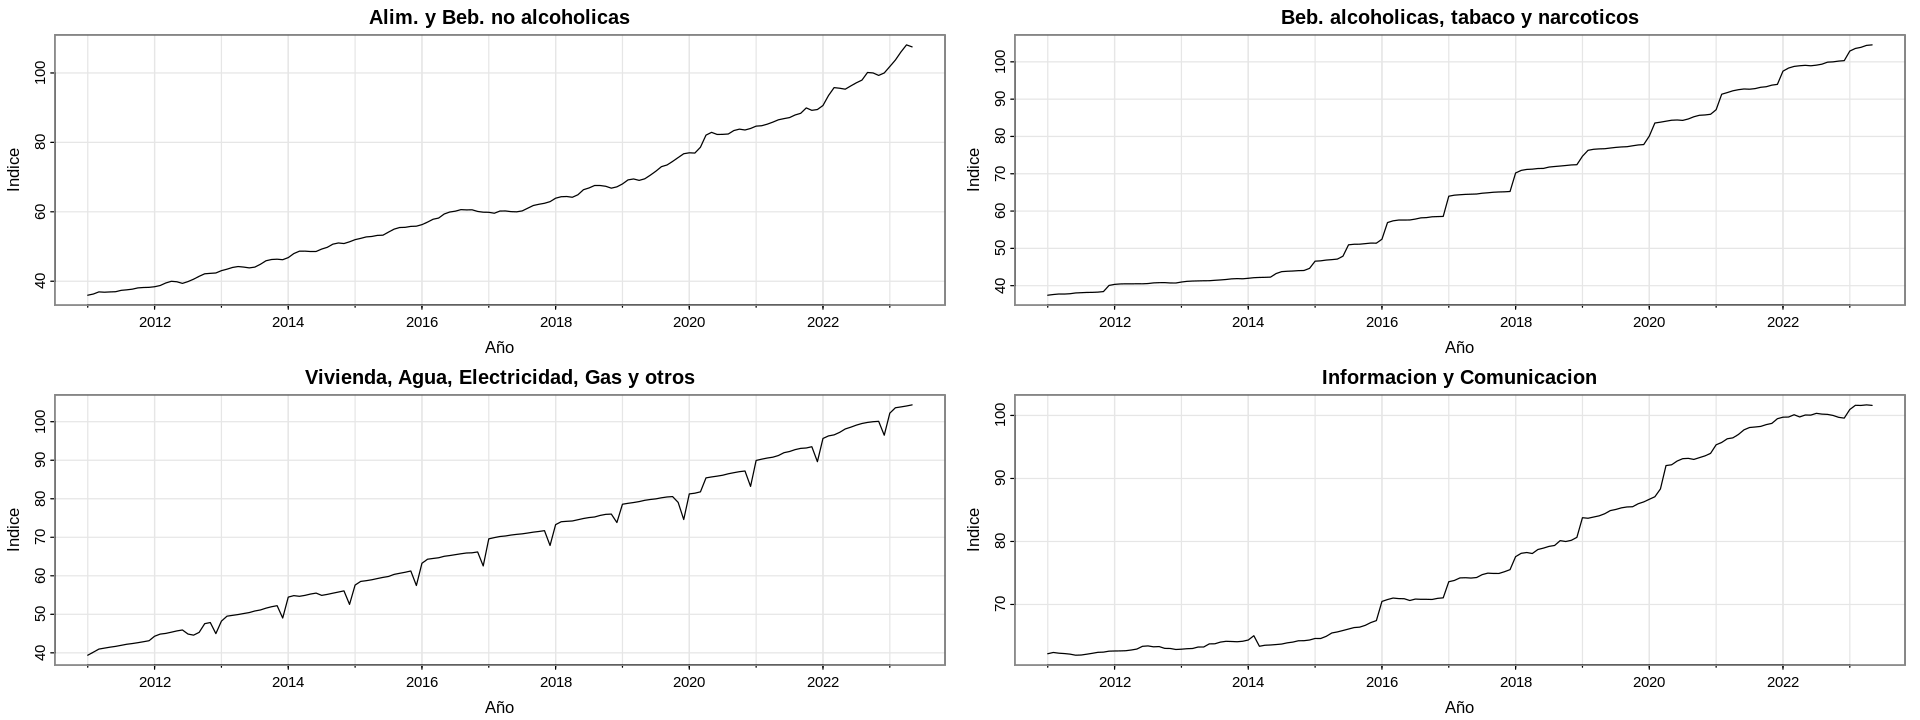

In [2]:
# Cargo los datos de un csv que previamente fue subido a github
df <- read.csv("Series.csv", sep=";")
df <- na.omit(df)

# Elijo 4 series (dos de Transables y dos de No Transables) que sean lo mas diferentes posibles 
serie1 <- ts(data=df$Alimentos.Y.Bebidas.No.Alcohólicas, start = 2011, frequency=12)
serie2 <- ts(data=df$Bebidas.Alcohólicas..Tabaco.Y.Narcóticos, start = 2011, frequency=12)
serie3 <- ts(data=df$Vivienda..Agua..Electricidad..Gas.Y.Otros.Combustibles, start = 2011, frequency=12)
serie4 <- ts(data=df$Información.Y.Comunicación, start = 2011, frequency=12)

nombres <- list("Alim. y Beb. no alcoholicas",
                "Beb. alcoholicas, tabaco y narcoticos",
                "Vivienda, Agua, Electricidad, Gas y otros",
                "Informacion y Comunicacion")
series <- list("serie1","serie2","serie3","serie4")

# Grafico las series elegidas
par(mfrow=c(2,2))
for(i in 1:length(series)){
  tsplot(get( as.character(series[i]) ), 
         main=nombres[[i]],
         ylab="Indice", xlab="Año")
}

#### Genero los grupos de Train y Validation

In [3]:
# Genero las series para train y validation
largo_series <- nrow(df)
meses_a_pred <- 7
serie1_train <- ts(serie1[ 1:(largo_series-meses_a_pred) ], start = 2011, frequency=12)
serie2_train <- ts(serie2[ 1:(largo_series-meses_a_pred) ], start = 2011, frequency=12)
serie3_train <- ts(serie3[ 1:(largo_series-meses_a_pred) ], start = 2011, frequency=12)
serie4_train <- ts(serie4[ 1:(largo_series-meses_a_pred) ], start = 2011, frequency=12)
serie1_validation <- ts(tail(serie1, meses_a_pred), start=2022 + 10/12 , frequency=12)
serie2_validation <- ts(tail(serie2, meses_a_pred), start=2022 + 10/12 , frequency=12)
serie3_validation <- ts(tail(serie3, meses_a_pred), start=2022 + 10/12 , frequency=12)
serie4_validation <- ts(tail(serie4, meses_a_pred), start=2022 + 10/12 , frequency=12)

dates <- seq(as.Date("2022-11-01"), by = "month", along = serie1_validation)

vector_series_tr <- list("serie1_train", "serie2_train", "serie3_train", "serie4_train")
vector_series_val <- list("serie1_validation", "serie2_validation", "serie3_validation", "serie4_validation")

## 2. Ajuste de las series con algoritmo autoarima

[1] "Alim. y Beb. no alcoholicas --> se ajusta con ARIMA(2,2,3)(1,0,0)[12]"
[1] "Beb. alcoholicas, tabaco y narcoticos --> se ajusta con ARIMA(0,1,1)(1,1,1)[12]"
[1] "Vivienda, Agua, Electricidad, Gas y otros --> se ajusta con ARIMA(1,1,1)(0,1,1)[12]"
[1] "Informacion y Comunicacion --> se ajusta con ARIMA(0,2,1)(1,0,1)[12]"


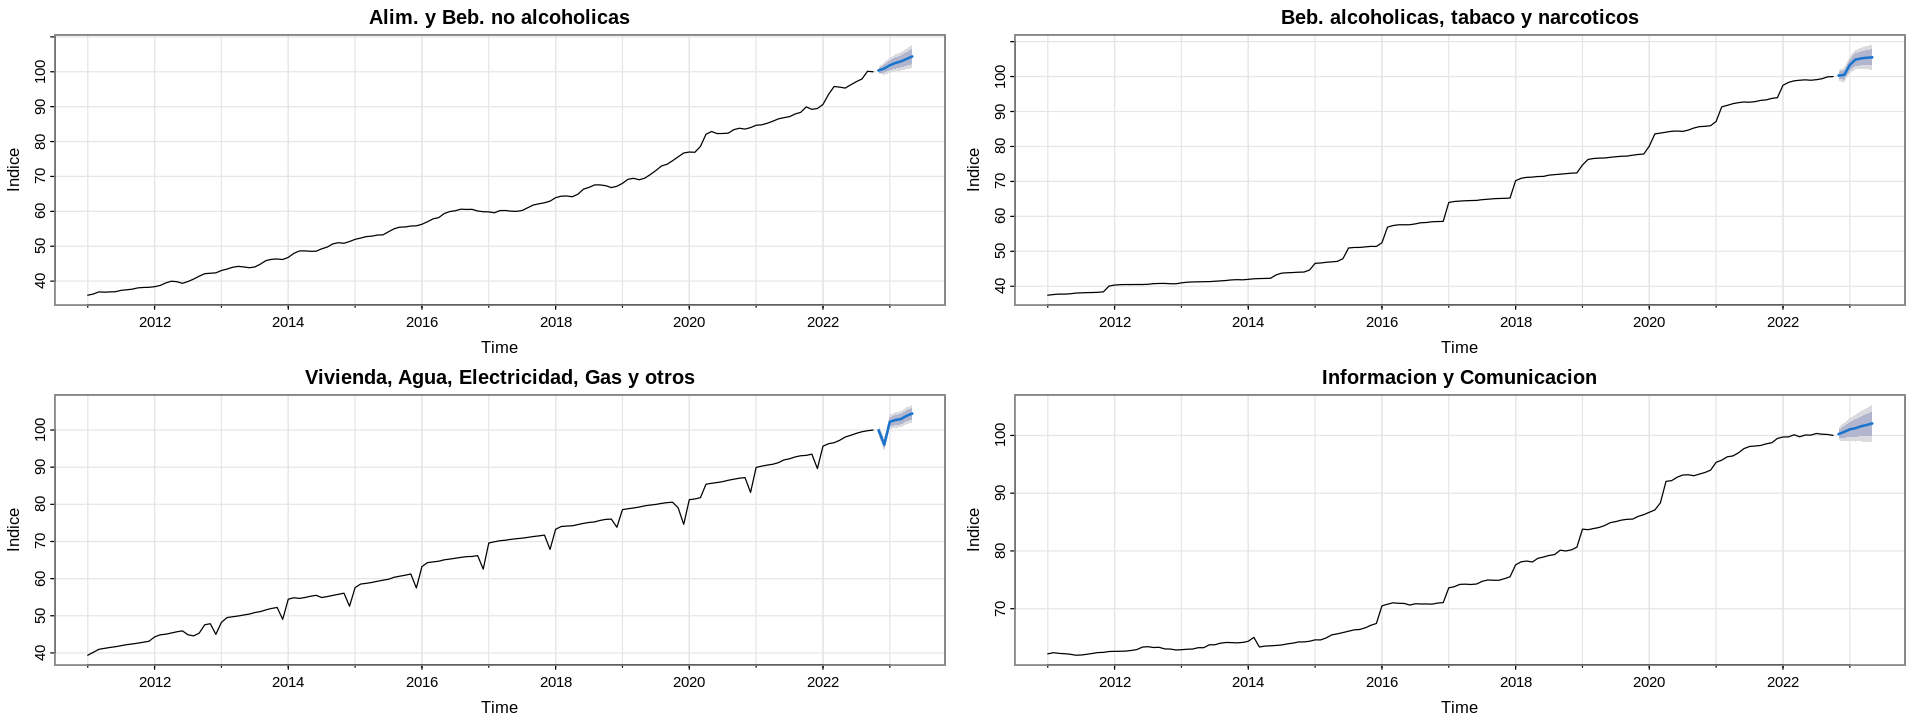

In [4]:
# Entreno las series con algoritmos auto.arima, y genero las predicciones
vector_modelos <- list() 
vector_ajustes <- list()
vector_arima_orders <- list()
vector_predicciones <- list()
rmse_train <- list()
rmse_val <- list() # aquí se guardará el rmse de cada auto arima

# Grafico las predicciones con su intervalo de confianza
par(mfrow=c(2,2))
for(i in 1:length(vector_series_tr)){
    r <- get(vector_series_tr[[i]])
    fit <- auto.arima(r)
    vector_modelos[[i]] <- fit
    vector_ajustes[[i]] <- fitted(fit)
    vector_arima_orders[[i]] <- arimaorder(fit)
    vector_predicciones[[i]] <- forecast(vector_modelos[[i]], h=meses_a_pred)
    print(paste(nombres[[i]], "--> se ajusta con", vector_predicciones[[i]]$method ))
    rmse_train[[i]] <- sd(fitted(fit) - get(vector_series_tr[[i]]))
    rmse_val[[i]] <- sd(vector_predicciones[[i]]$mean - get(vector_series_val[[i]]))
    tsplot(vector_predicciones[[i]], main=nombres[[i]], ylab="Indice")
#     text(x=dates[6], y=92, paste("RMSE_train:", round(rmse_train[[i]],4)), pos = 3, col = "steelblue", cex = 1.5, font = 2)
}

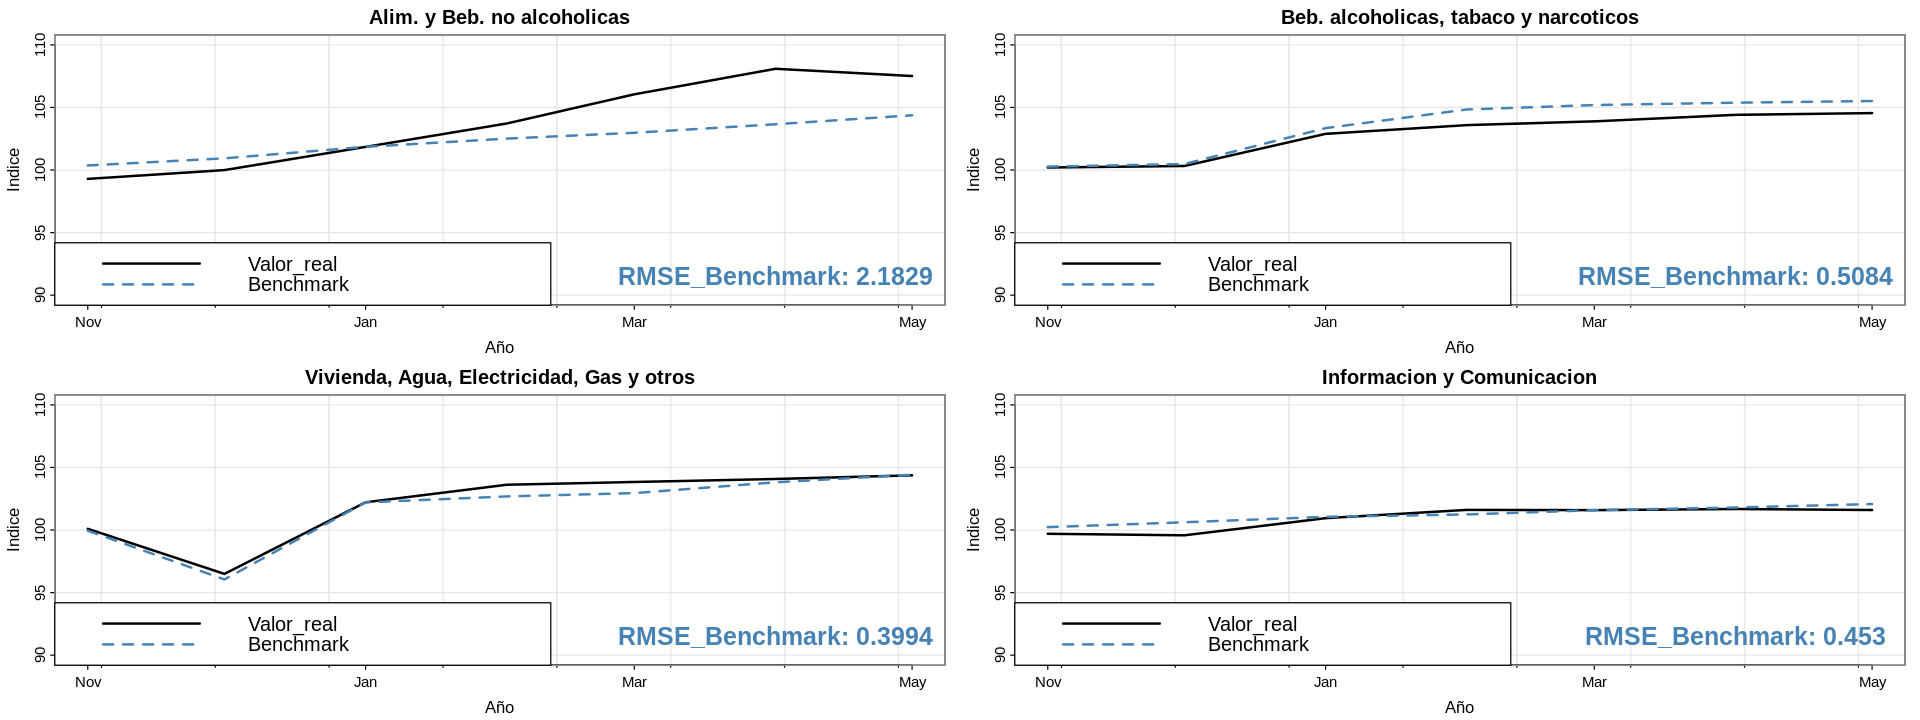

In [5]:
# Grafico los valores reales de la serie vs la prediccion generada con auto.arima
par(mfrow=c(2,2))
for(i in 1:length(vector_series_val)){
    tsplot(x=dates, y=get(vector_series_val[[i]]), main=nombres[[i]], lwd=2, ylim=c(90,110), ylab="Indice", xlab="Año")
    lines(x=dates, y=vector_predicciones[[i]]$mean, col="steelblue", lwd=2, lty="dashed")
    legend("bottomleft", legend=c("Valor_real", "Benchmark"), col=c("black", "steelblue"), cex=1.2, lty=c(1,2), lwd=c(2,2))
    text(x=dates[6], y=90, paste("RMSE_Benchmark:", round(rmse_val[[i]],4)), pos = 3, col = "steelblue", cex = 1.5, font = 2)
}

## 3. Analisis de Series

### 3.1 Alimentos y Bebidas no Alcohólicas

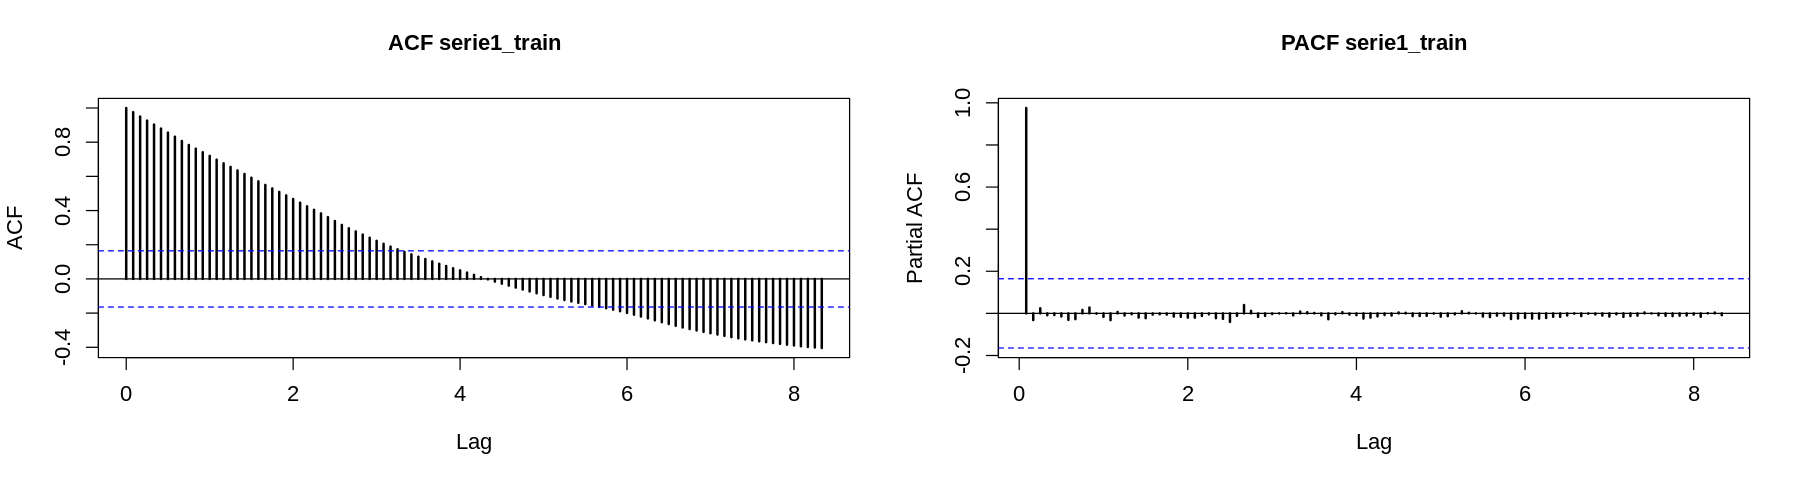

In [6]:
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
options(repr.plot.width=15, repr.plot.height=4)
acf(serie1_train, main="ACF serie1_train", 100, lwd=2)
pacf(serie1_train, main="PACF serie1_train", 100, lwd=2)

El acf decae exponencialmente, mientras que el PACF se apaga luego del primer lag. A priori la serie pareceria ser un AR(1)


	Augmented Dickey-Fuller Test

data:  residuals(fit)
Dickey-Fuller = -3.8979, Lag order = 5, p-value = 0.01627
alternative hypothesis: stationary


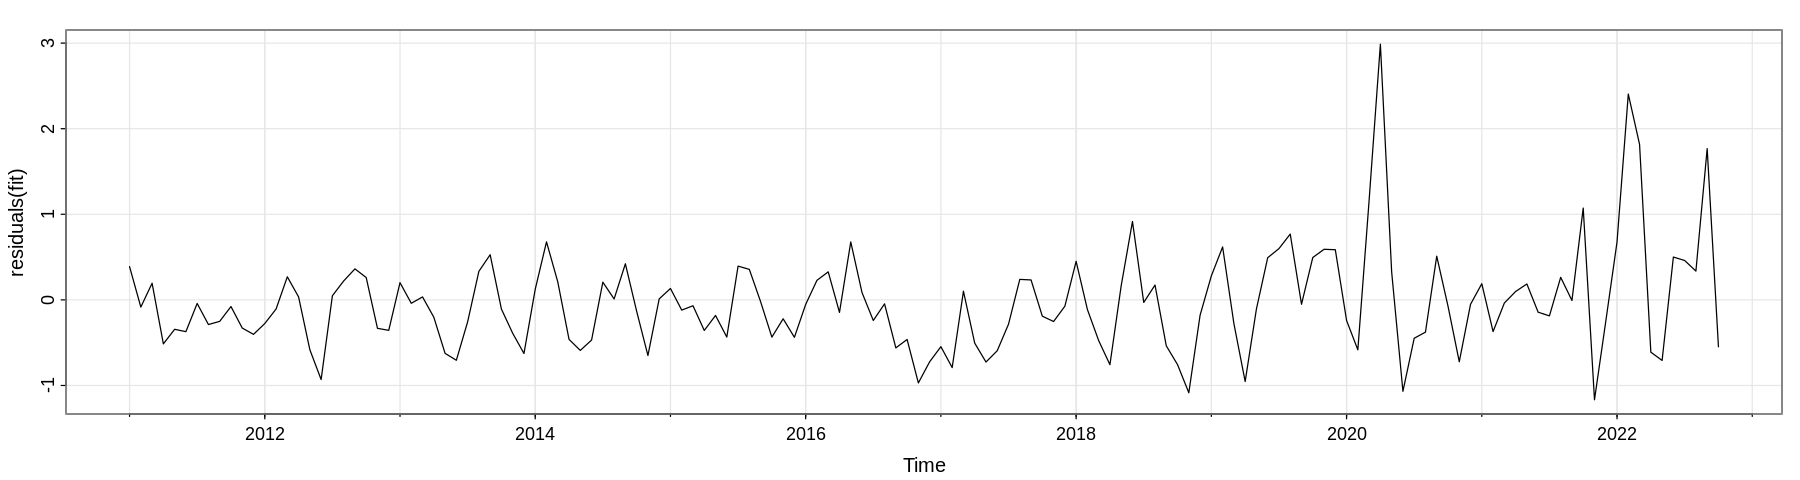

In [7]:
# PRIMER AJUSTE -- AR(1)
fit <- Arima(serie1_train, order=c(1,0,0), include.drift = TRUE)
tsplot(residuals(fit))
adf.test(residuals(fit))
    # Como p-valor < 0.05 --> No se puede rechazar la hipotesis nula --> Los residuos NO son estacionarios

Se observa que los residuos del ajuste no son blancos --> Se prueba la serie con diff(log()) 

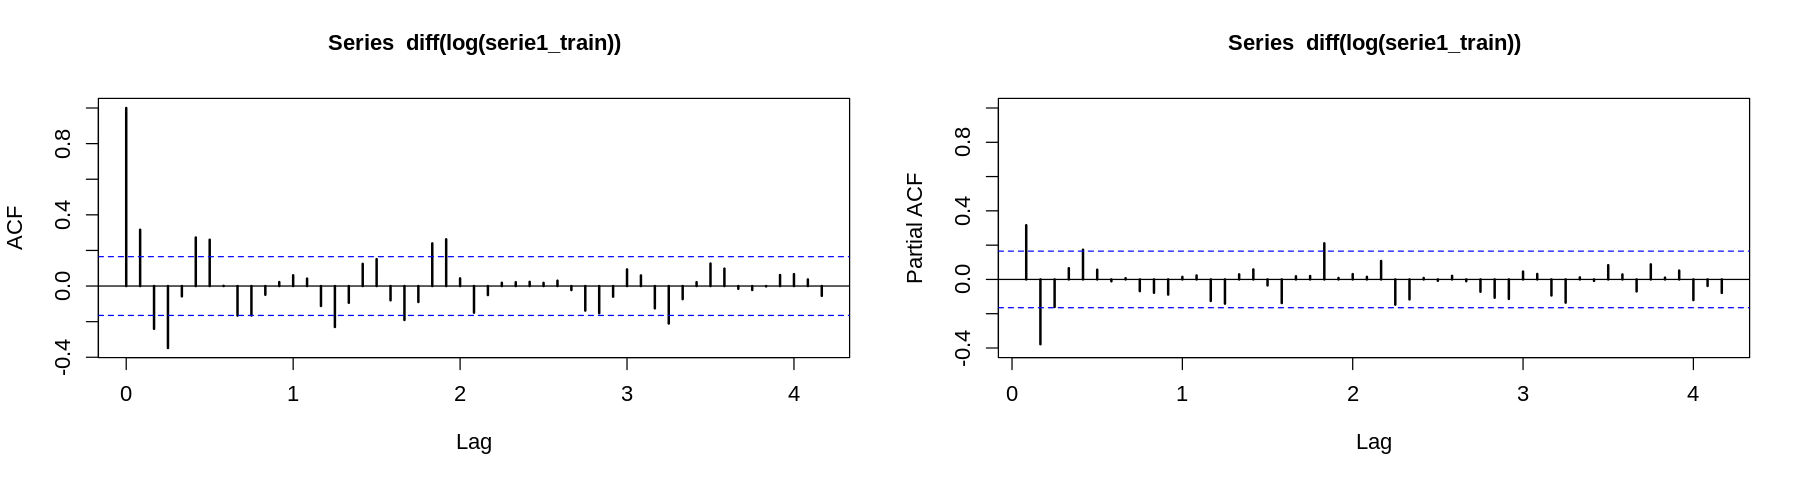

In [8]:
# SEGUNDO AJUSTE -- aplicando diff(log()) y diff(log(), 12)
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
acf(diff(log(serie1_train)), 50, lwd=2)
pacf(diff(log(serie1_train)), 50, lwd=2, ylim=c(-0.4, 1))

El pacf pareceria apagarse luego del 2 lag, mientras que el acf lo hace luego del tercero. Se propone un ARIMA(2,2,3)(0,2,0).
El valor de I=2 porque se consideraron dos diferencias.

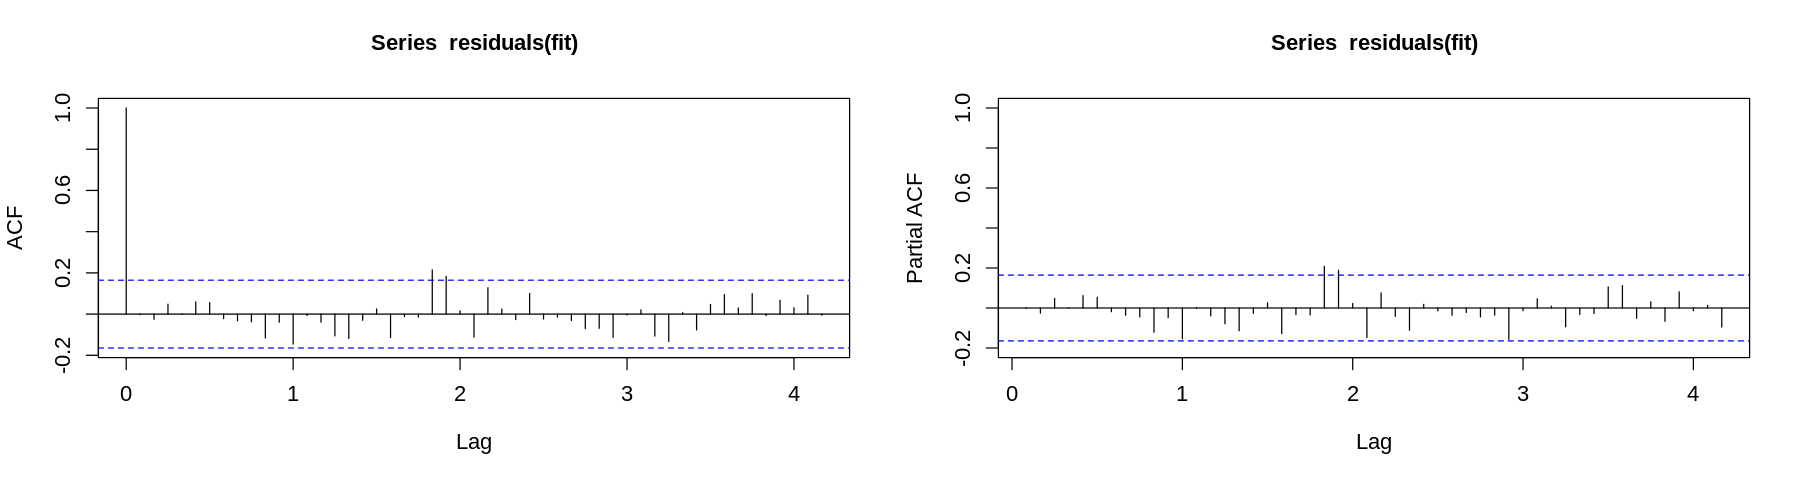

In [9]:
fit <- Arima(serie1_train, order=c(2,2,3))#, seasonal=c(0,2,0))
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
acf(residuals(fit), 50)
pacf(residuals(fit), 50, ylim=c(-0.2, 1))

El lag1 estacional del pacf parecería ser estacionario --> Se propone un ARIMA(2,2,3)(1,2,0)

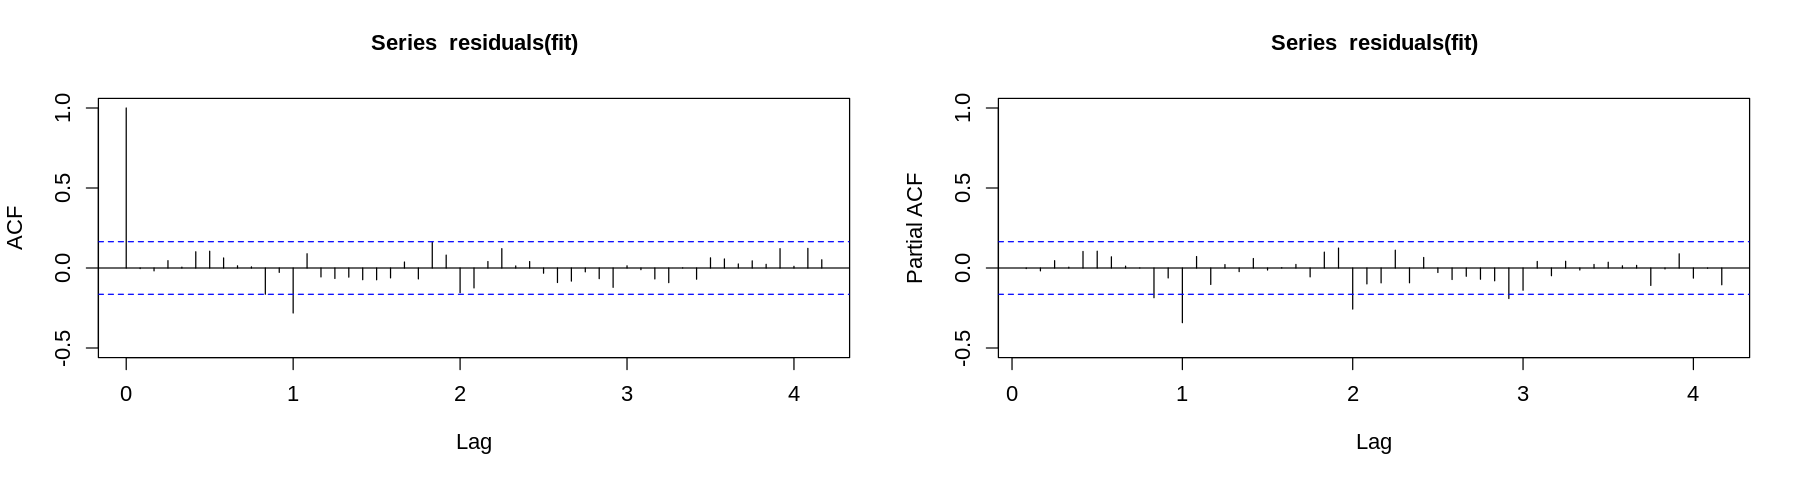

In [10]:
fit <- Arima(serie1_train, order=c(2,2,3), seasonal=c(1,2,0))
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
acf(residuals(fit), 50, ylim=c(-0.5, 1))
pacf(residuals(fit), 50, ylim=c(-0.5, 1))

Ahora se suman el lag1 estacional del acf, y el lag2 estacional del pacf --> Se propone un ARIMA(2,2,3)(2,2,1)

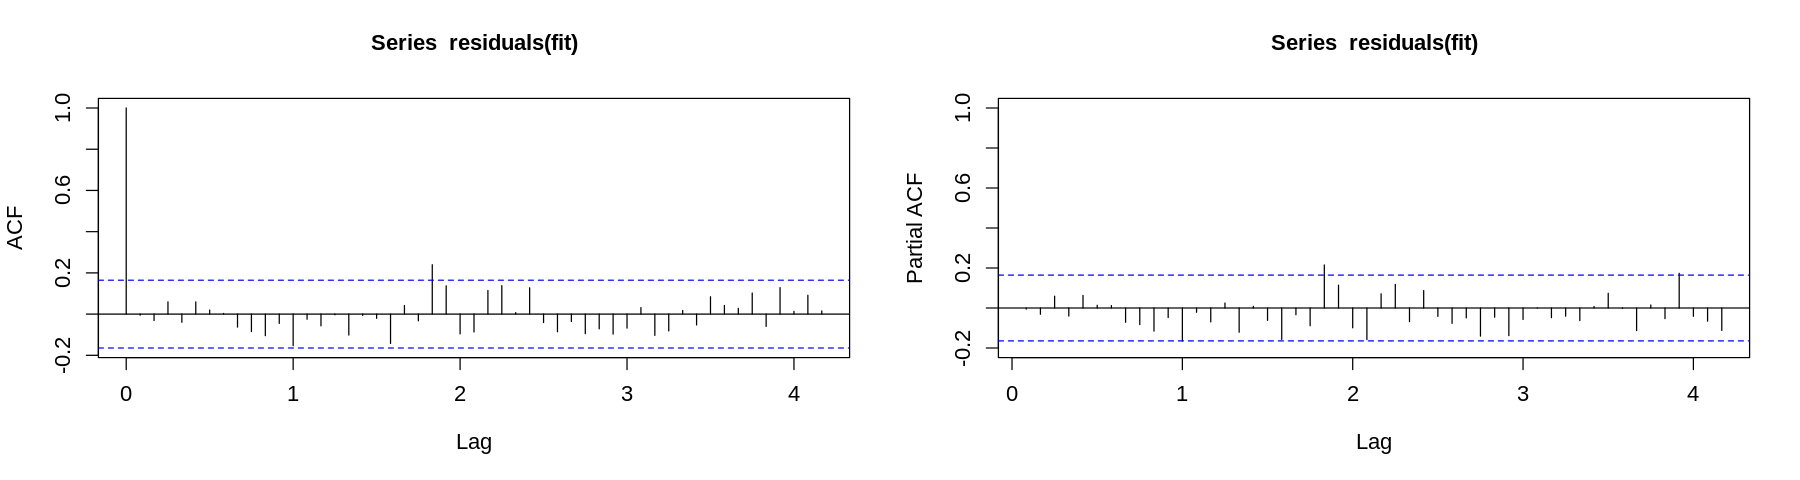

In [11]:
fit <- Arima(serie1_train, order=c(2,2,3), seasonal=c(2,2,1))
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
acf(residuals(fit), 50)
pacf(residuals(fit), 50, ylim=c(-0.2,1))

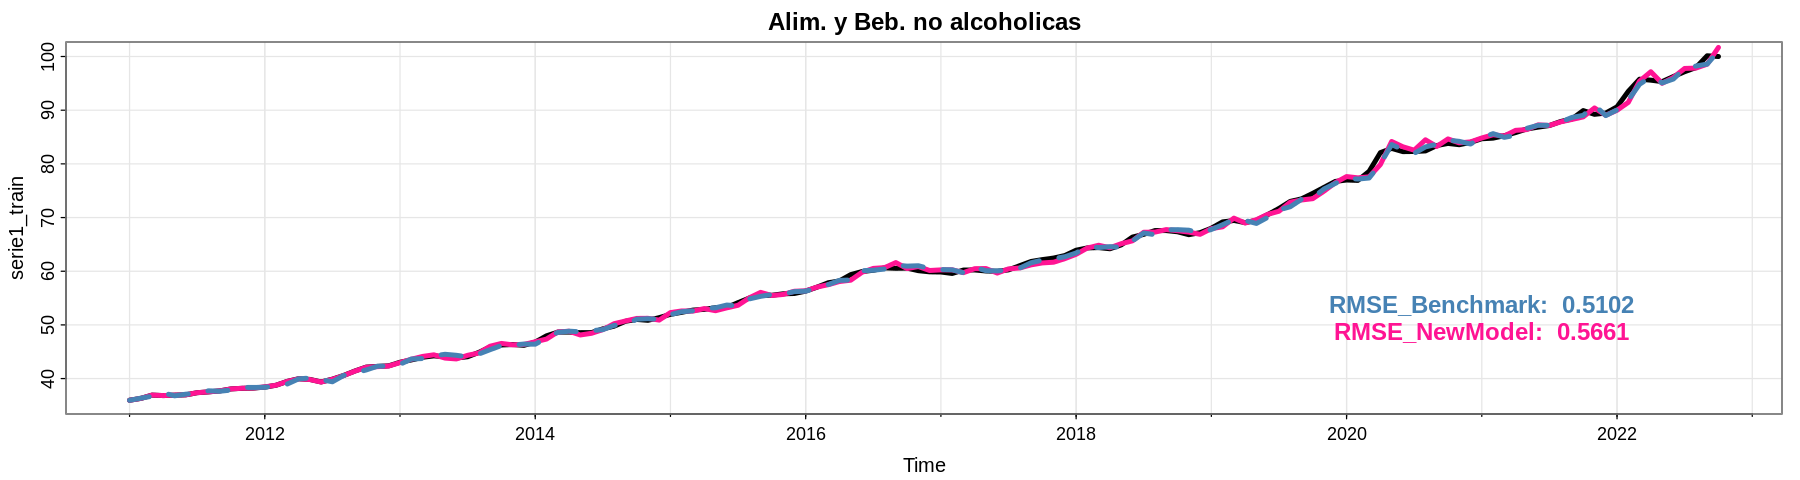

In [12]:
tsplot(serie1_train, main=nombres[[1]], col="black", lwd=4)
rmse_m1_train <- sd(fitted(fit) - serie1_train)
lines(fitted(fit), col="deeppink", lwd=4)
lines(vector_ajustes[[1]], col="steelblue", lwd=4, lty=2)
text(x=c(2021,2), y=50, paste("RMSE_Benchmark: ", round(rmse_train[[1]],4)),pos = 3, col = "steelblue", cex = 1.2, font = 2)
text(x=c(2021,2), y=45, paste("RMSE_NewModel: ", round(rmse_m1_train,4)),pos = 3, col = "deeppink", cex = 1.2, font = 2)

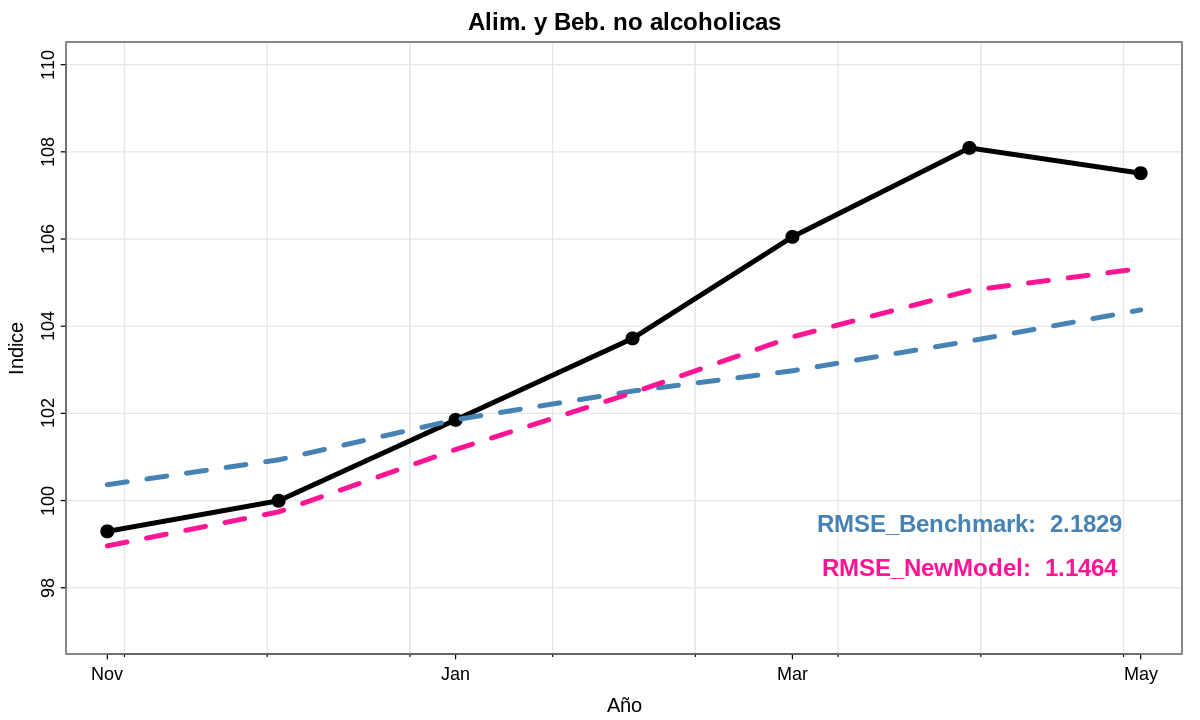

In [13]:
layout(1)
options(repr.plot.width=10, repr.plot.height=6)
pred1 <- forecast(fit, h=7)
tsplot(x=dates, y=serie1_validation, col="black", lwd=4, ylim=c(97, 110),ylab="Indice", xlab="Año", main=nombres[[1]])
points(x=dates, y=serie1_validation, col="black", lwd=4)
lines(x=dates, y=vector_predicciones[[1]]$mean, col="steelblue", lty="dashed", lwd=4)
lines(x=dates, y=pred1$mean, col="deeppink", lty="dashed", lwd=4)
rmse_m1_val <- sd(pred1$mean - serie1_validation)
text(x=dates[6], y=99, paste("RMSE_Benchmark: ", round(rmse_val[[1]],4)),pos = 3, col = "steelblue", cex = 1.2, font = 2)
text(x=dates[6], y=98, paste("RMSE_NewModel: ", round(rmse_m1_val,4)),pos = 3, col = "deeppink", cex = 1.2, font = 2)

En el conjunto de datos Train el rmse generado por el algoritmo auto arima fue menor que en el modelo propuesto. Sin embargo, en validation se da la situación opuesta, lo que indicaría un posible overfitting del primero.

### 3.2 Bebidas Alcohólicas, Tabaco y Narcóticos

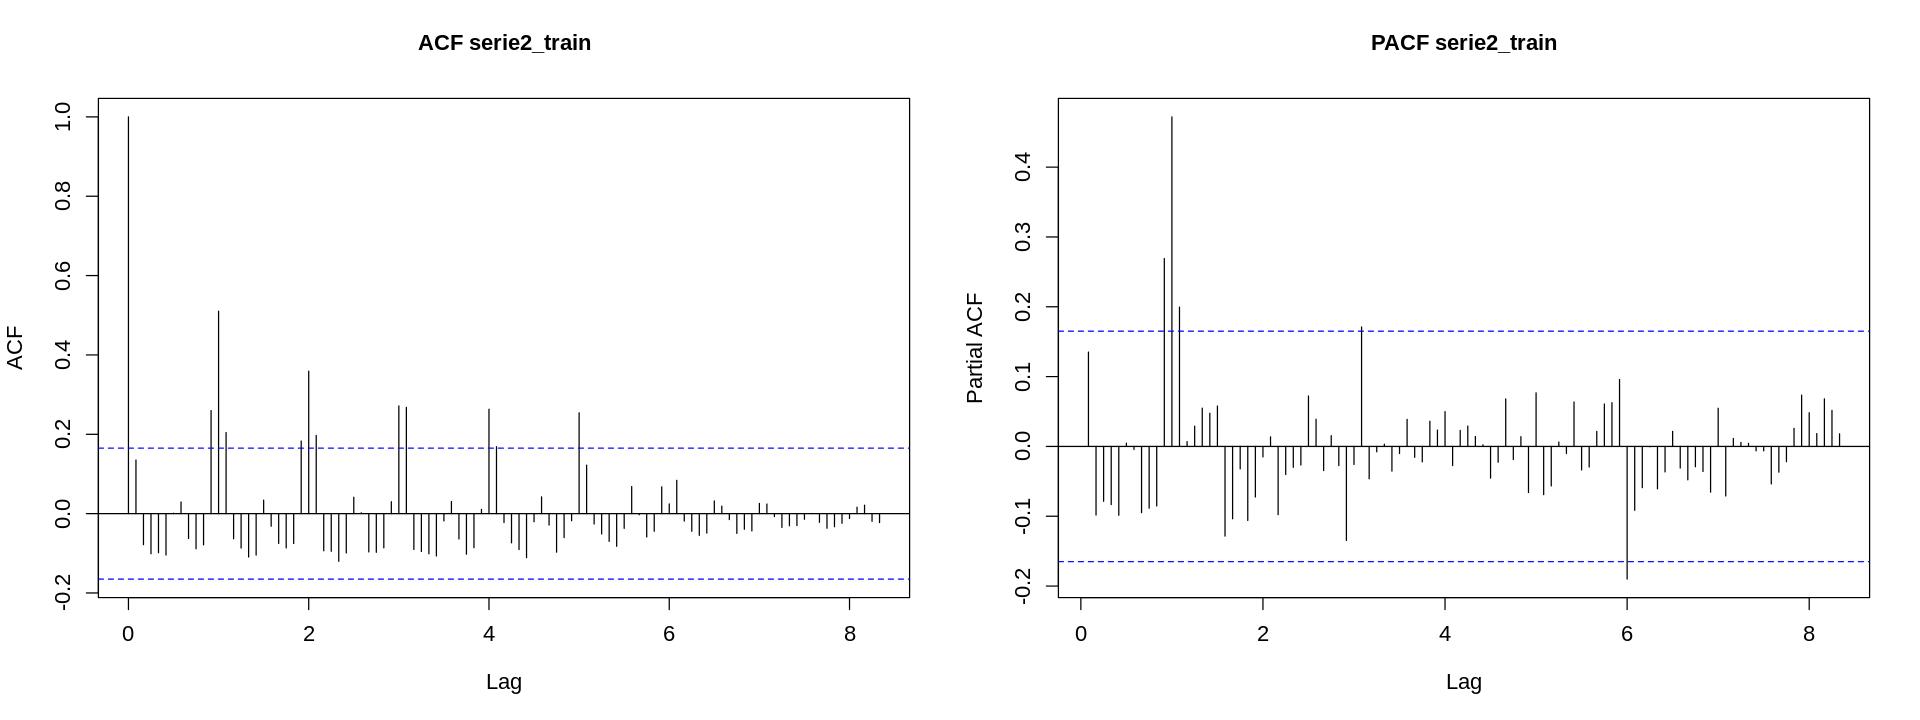

In [14]:
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
options(repr.plot.width=16, repr.plot.height=6)
acf(diff(serie2_train), main="ACF serie2_train", 100)
pacf(diff(serie2_train), main="PACF serie2_train", 100)

Misma situación de la serie anterior. Se comienza por ajustar un modelo ARIMA(0,1,0)(0,1,0)

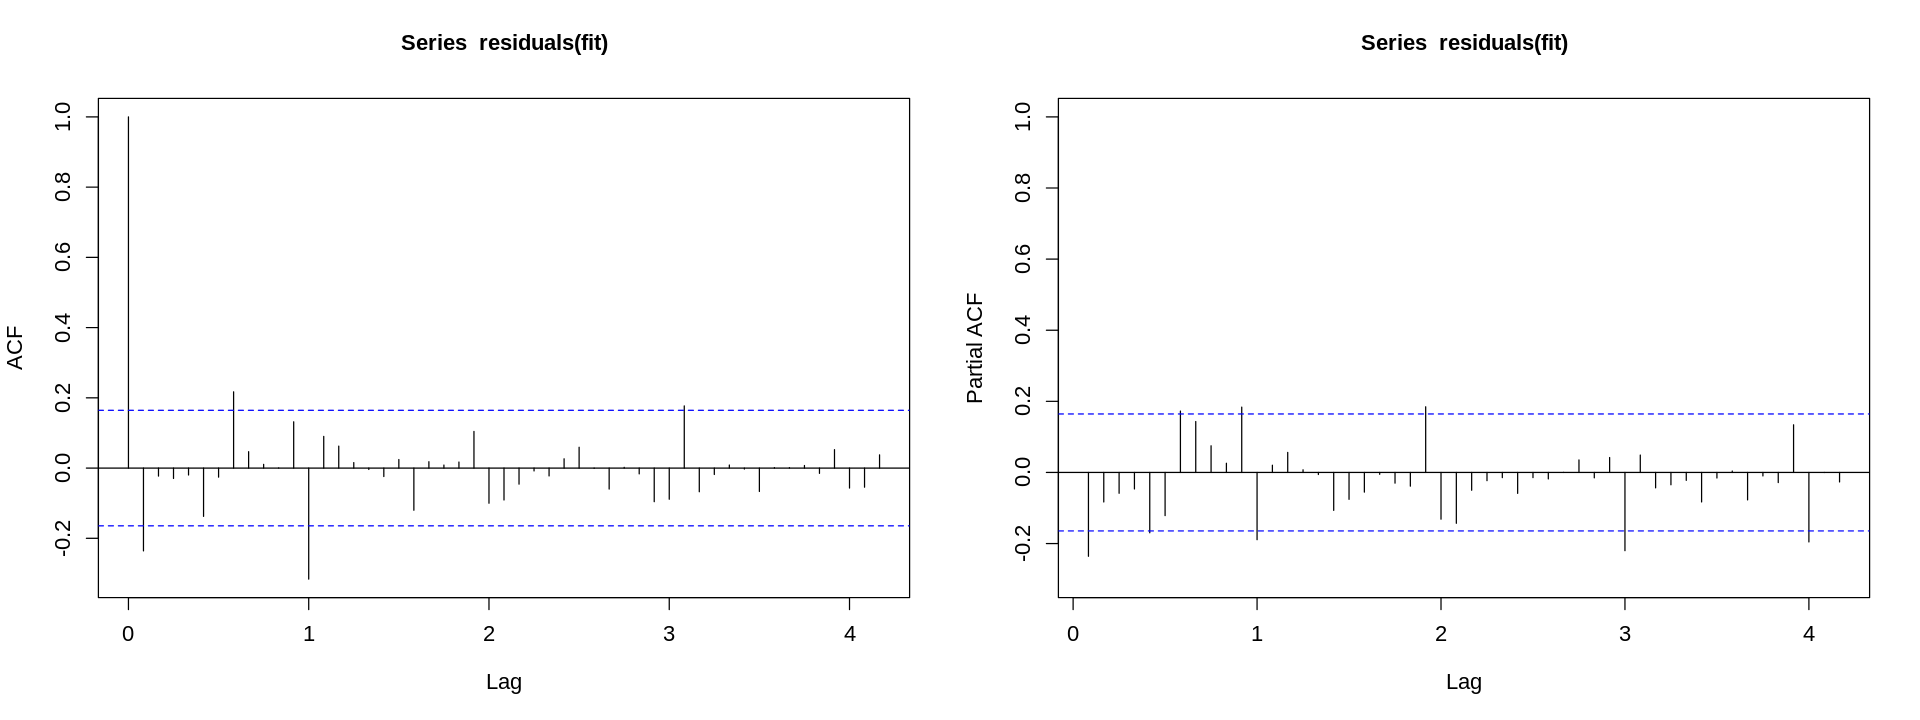

In [15]:
# PRIMER AJUSTE
fit <- Arima(serie2_train, order=c(0,1,0), seasonal=c(0,1,0))
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
acf(residuals(fit), 50)
pacf(residuals(fit), 50, ylim=c(-0.3,1))

El lag1 de acf y pacf, asi como el lag1 estacional de acf y pacf, son estacionarios. Se prueba entonces ajustar un ARIMA(1,1,1)(1,1,1)

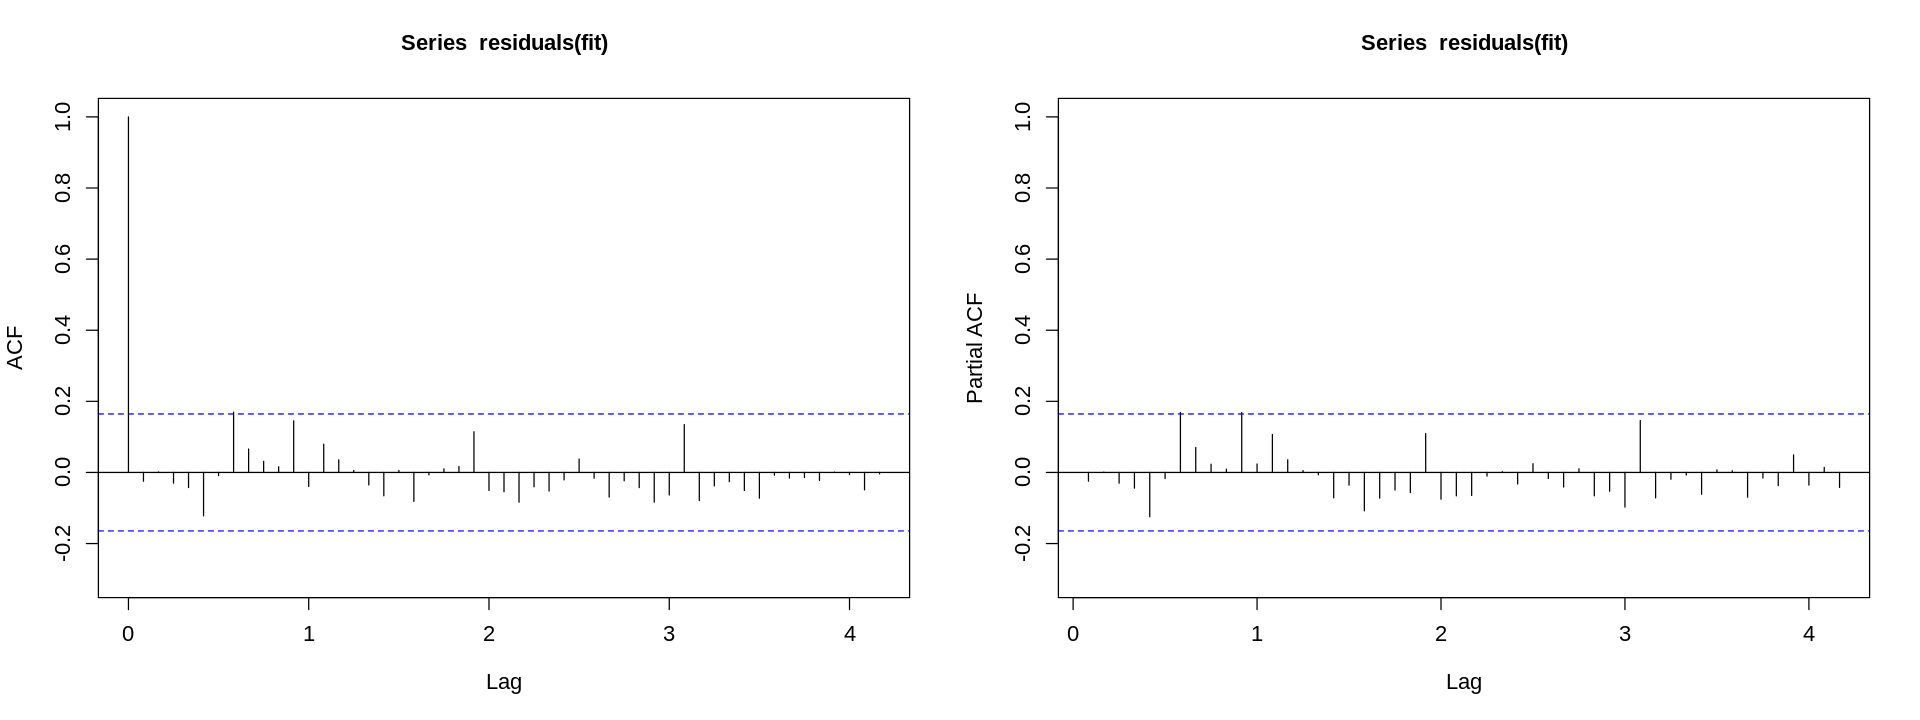

In [16]:
# SEGUNDO AJUSTE
fit <- Arima(serie2_train, order=c(1,1,1), seasonal=c(1,1,1))
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
acf(residuals(fit), 50, ylim=c(-0.3,1))
pacf(residuals(fit), 50, ylim=c(-0.3,1))

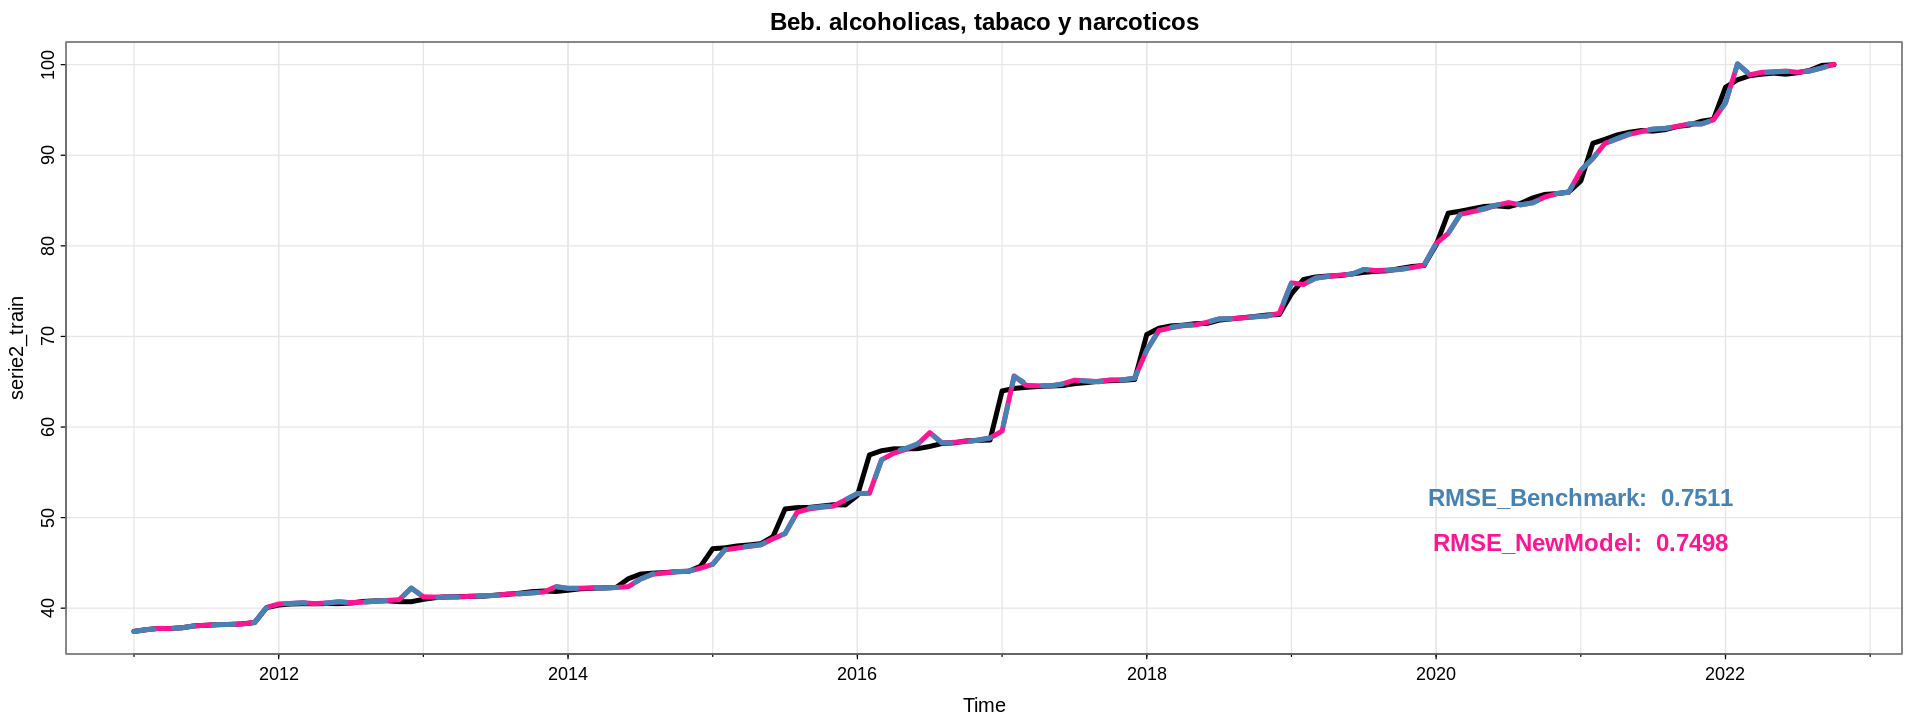

In [17]:
tsplot(serie2_train, main=nombres[[2]], col="black", lwd=4)
rmse_m2_train <- sd(fitted(fit) - serie2_train)
lines(fitted(fit), col="deeppink", lwd=4)
lines(vector_ajustes[[2]], col="steelblue", lwd=4, lty=2)
text(x=c(2021,2), y=50, paste("RMSE_Benchmark: ", round(rmse_train[[2]],4)),pos = 3, col = "steelblue", cex = 1.2, font = 2)
text(x=c(2021,2), y=45, paste("RMSE_NewModel: ", round(rmse_m2_train,4)),pos = 3, col = "deeppink", cex = 1.2, font = 2)

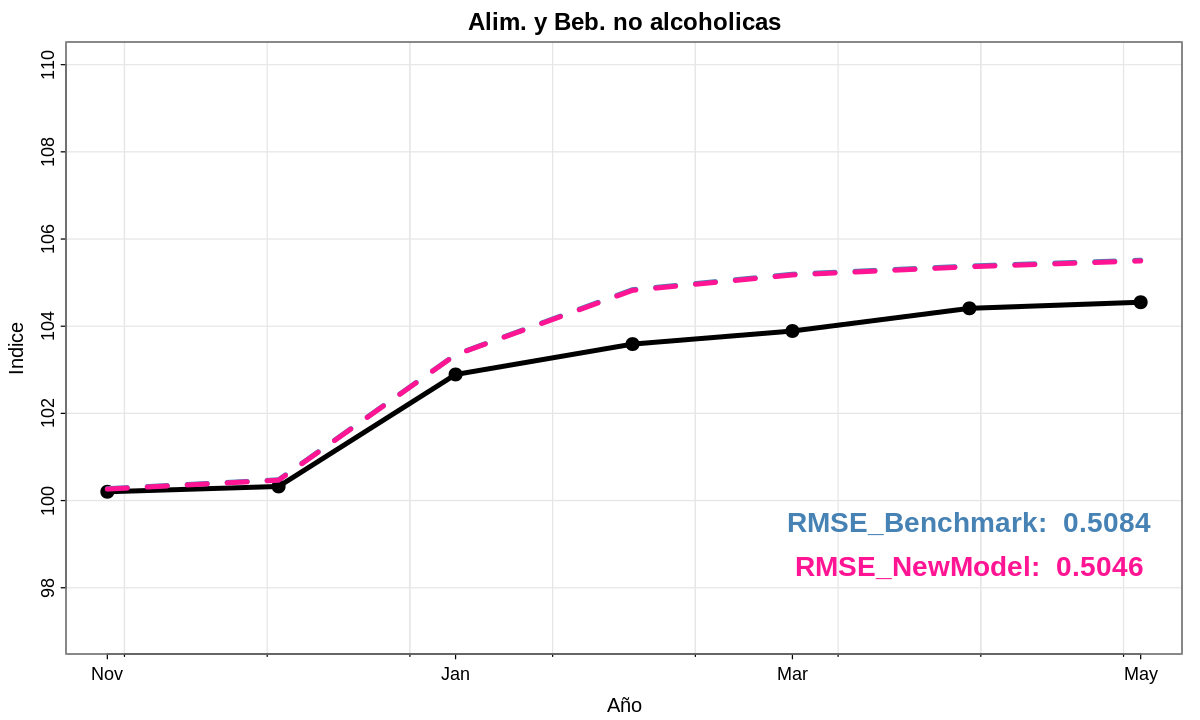

In [18]:
# PREDICCION
layout(1)
options(repr.plot.width=10, repr.plot.height=6)
pred2 <- forecast(fit, h=7)
tsplot(x=dates, y=serie2_validation, col="black", lwd=4, ylim=c(97, 110),ylab="Indice", xlab="Año", main=nombres[[1]])
points(x=dates, y=serie2_validation, col="black", lwd=4)
lines(x=dates, y=vector_predicciones[[2]]$mean, col="steelblue", lty="dashed", lwd=4)
lines(x=dates, y=pred2$mean, col="deeppink", lty="dashed", lwd=4)
rmse_m2_val <- sd(pred2$mean - serie2_validation)
text(x=dates[6], y=99, paste("RMSE_Benchmark: ", round(rmse_val[[2]],4)),pos = 3, col = "steelblue", cex = 1.4, font = 2)
text(x=dates[6], y=98, paste("RMSE_NewModel: ", round(rmse_m2_val,4)),pos = 3, col = "deeppink", cex = 1.4, font = 2)

El modelo propuesto es practicamente idéntico al generado con el algoritmo autoarima, por tanto se continúa el análisis realizandole a la serie una transformación Box-Cox.

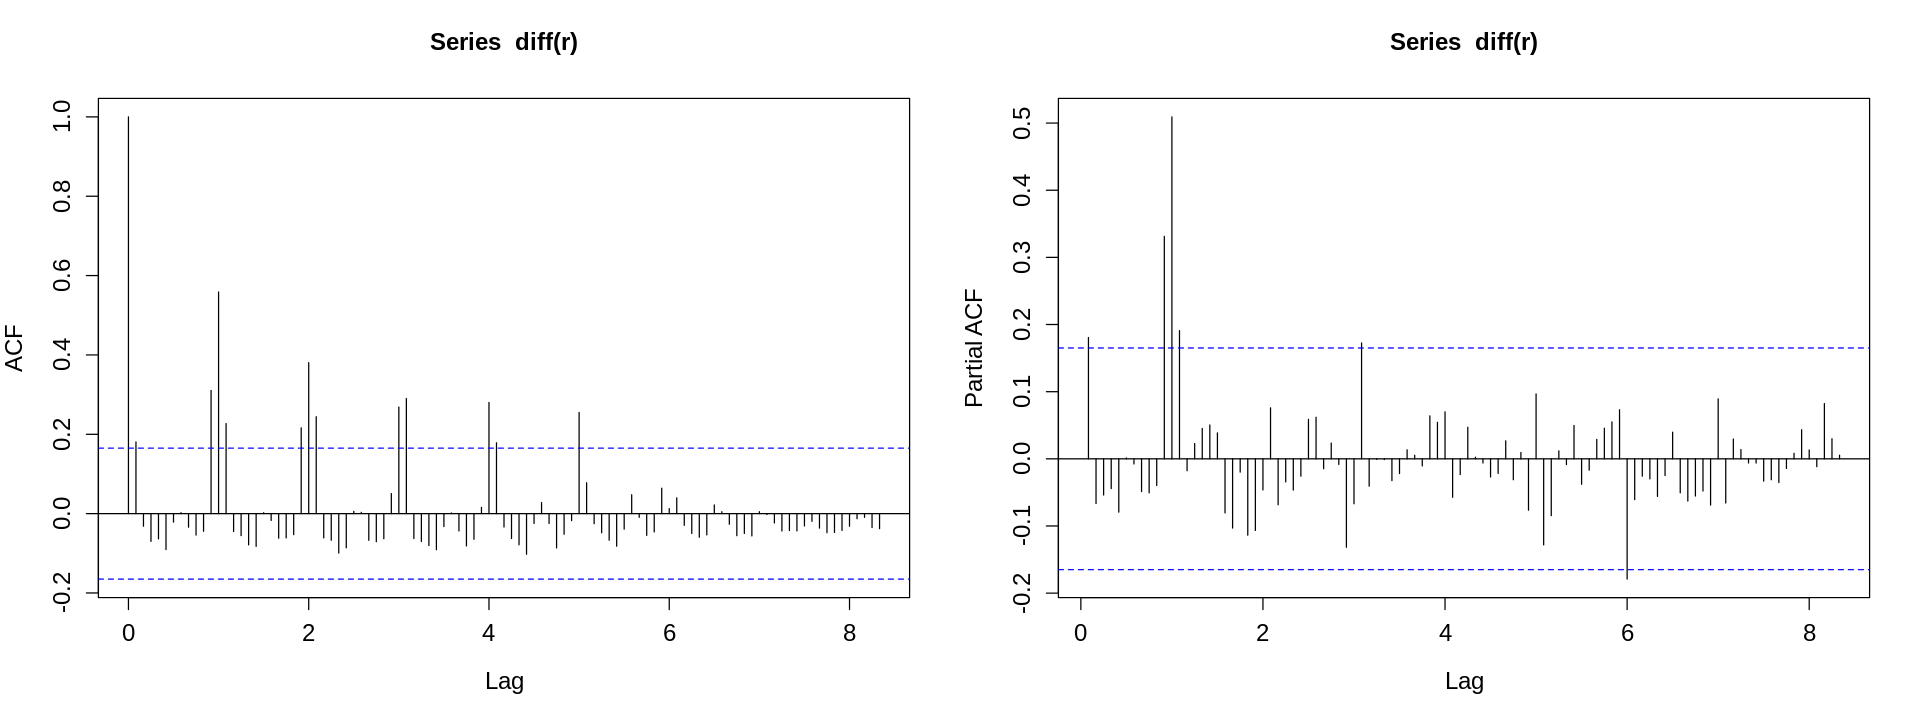

In [19]:
# TERCER AJUSTE -- Transformacion Box-Cox
options(repr.plot.width=16, repr.plot.height=6)
par(mfrow=c(1,2), cex.main=1.2, cex.lab=1.2, cex.axis=1.2)
lam <- 2
r <- ts(BoxCox(serie2_train, lambda=lam), start=2011, frequency=12)
acf(diff(r), 100)
pacf(diff(r), 100)

El lag1 de acf y pacf, y el lag1 estacional del pacf son significativo. Se propone un ARIMA(1,1,1)(1,1,0)

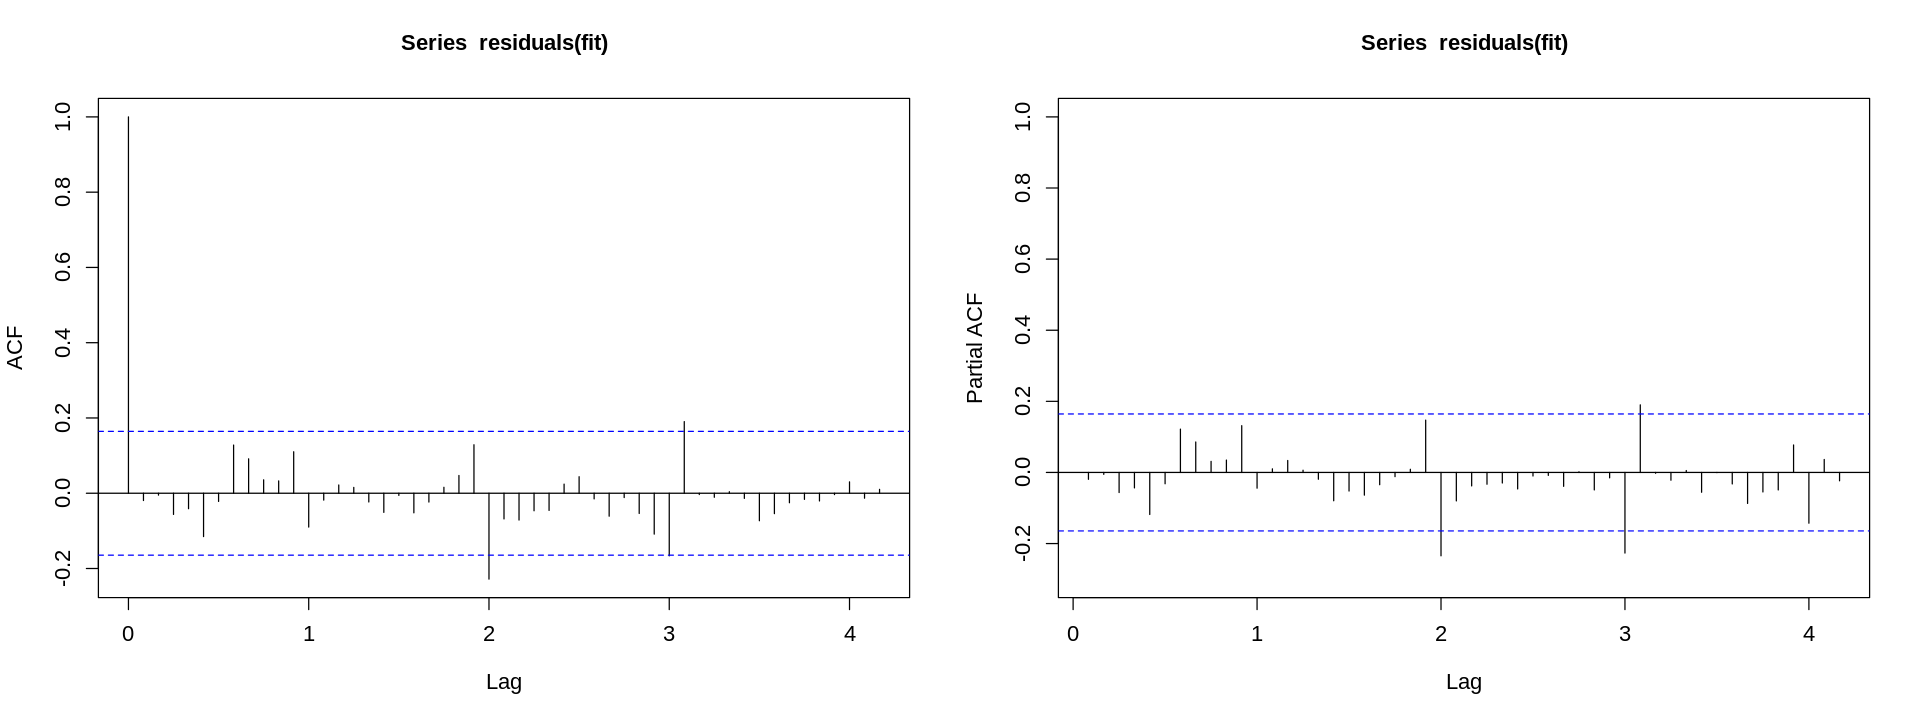

In [20]:
fit <- Arima(r, order=c(1,1,1), seasonal=c(1, 1, 0))
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
acf(residuals(fit), 50)
pacf(residuals(fit), 50, ylim=c(-0.3,1))

Se requiere un nuevo ajuste puesto que el lag2 estacional del acf es significativo. A su vez se observa que las componentes estacionales del pacf siguen sin ajustar bien, por lo que para una mejor lectura de los mismos se propone ajustar un ARIMA (1,1,1)(0,1,0)

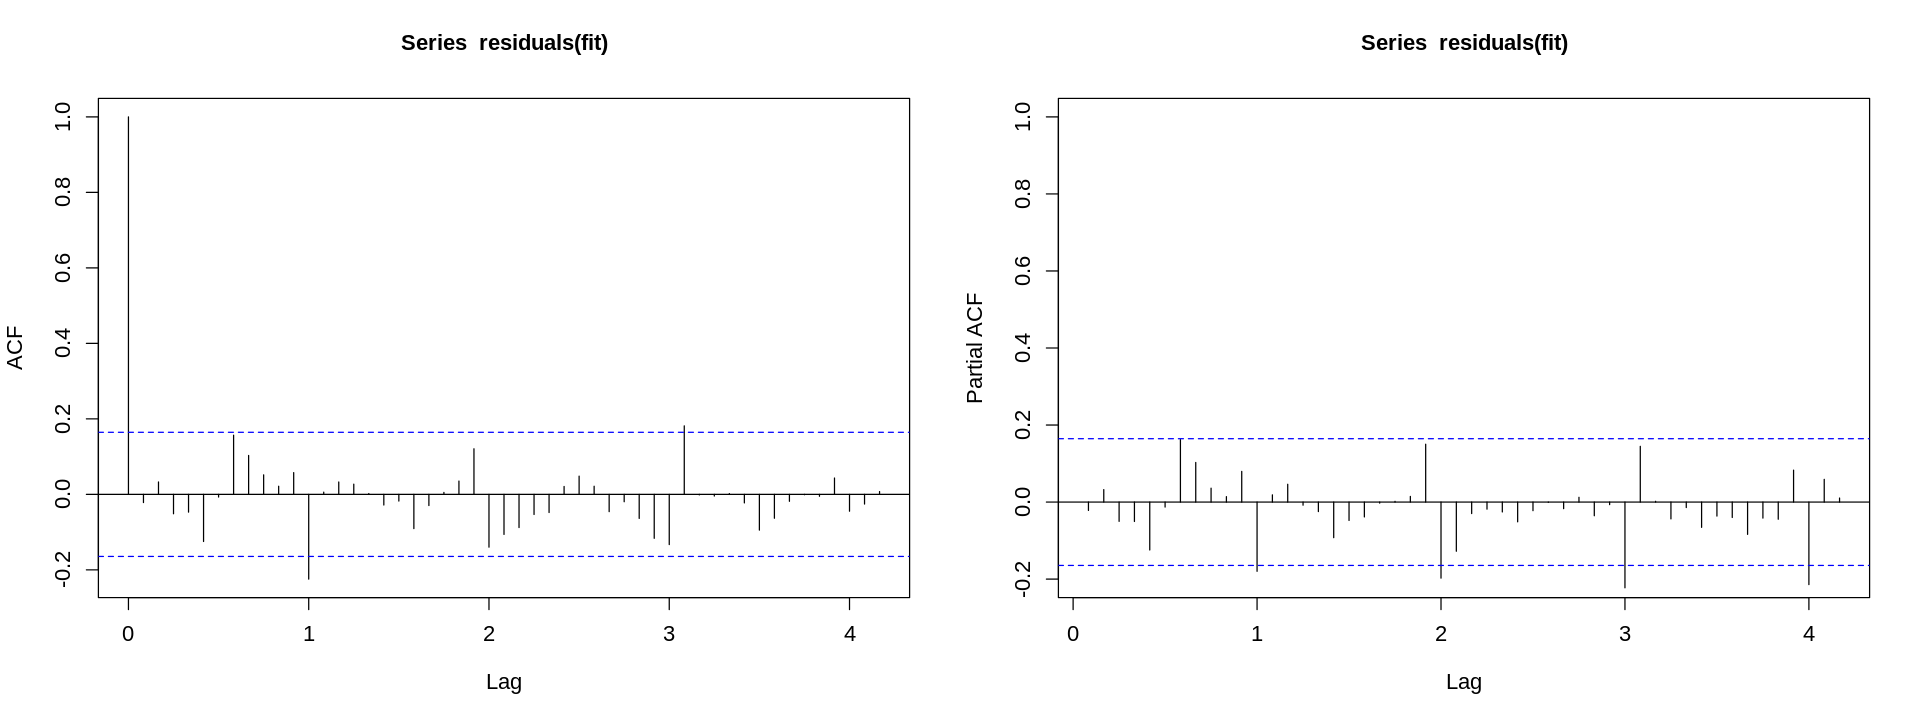

In [21]:
fit <- Arima(r, order=c(1,1,1), seasonal=c(0, 1, 0))
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
acf(residuals(fit), 50)
pacf(residuals(fit), 50, ylim=c(-0.2,1))

El primer lag estacional de acf es significativo, mientras que los lags estacionales del pacf siguen sin ajustar correctamente. Se propone entonces un ARIMA(1,1,1)(0,1,1)

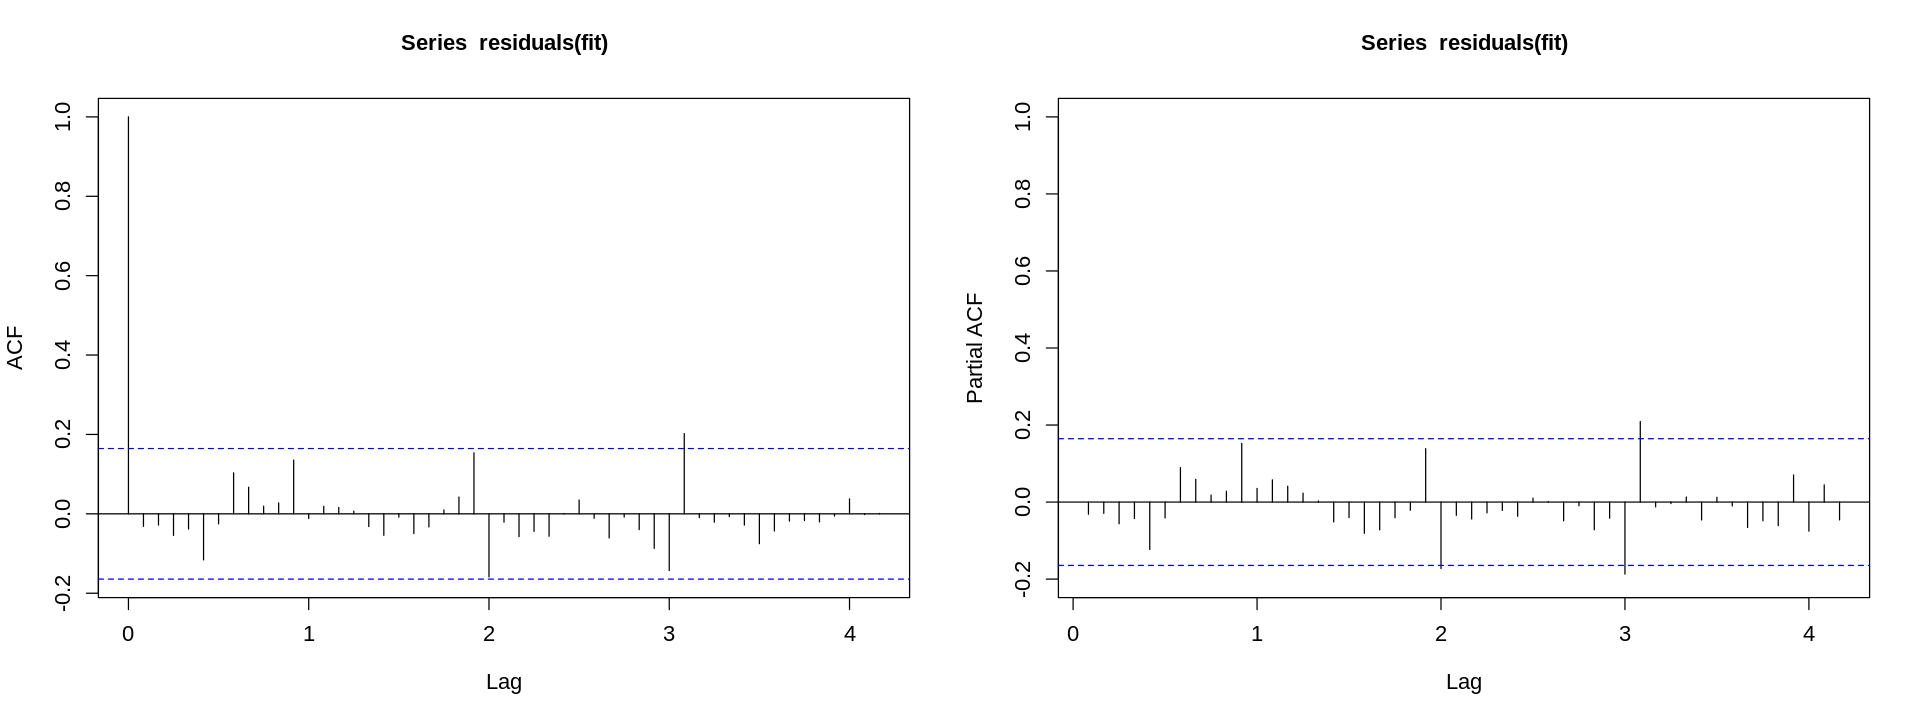

In [22]:
fit <- Arima(r, order=c(1,1,1), seasonal=c(0, 1, 1))
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
acf(residuals(fit), 50)
pacf(residuals(fit), 50, ylim=c(-0.2,1))

El lag2 está en el limite de significancia. Se propone incluirlo para ver si mejora el ajuste, por lo que el modelo quedaría ARIMA(1,1,1)(0,1,2)

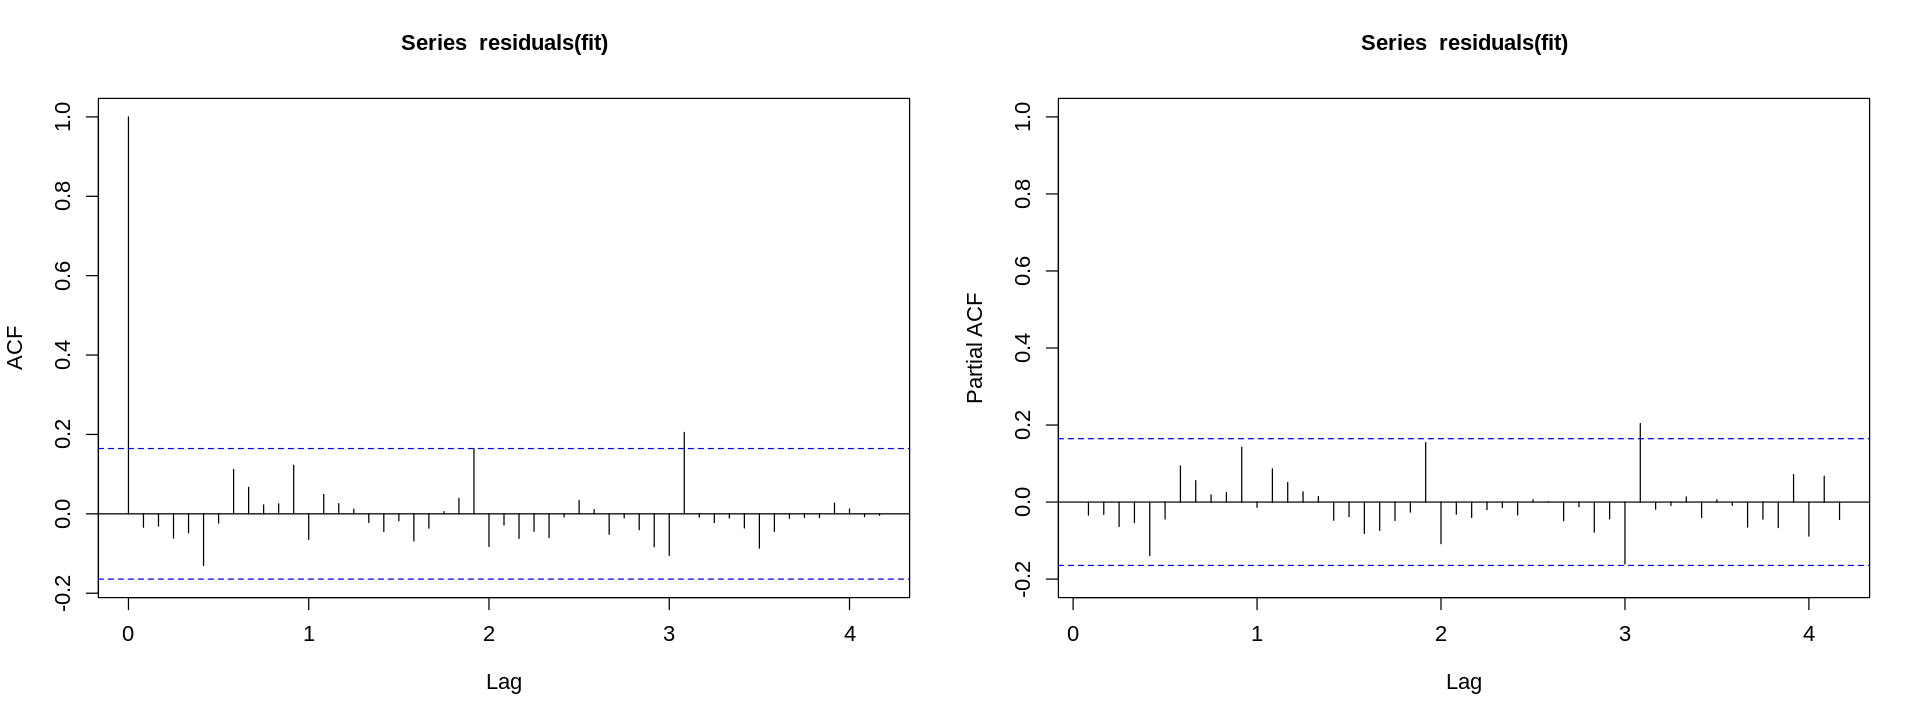

In [23]:
fit <- Arima(r, order=c(1,1,1), seasonal=c(0, 1, 2))
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
acf(residuals(fit), 50)
pacf(residuals(fit), 50, ylim=c(-0.2,1))

Las componentes estacionales parecen haberse corregido, por lo que se realizan las predicciones con este último modelo

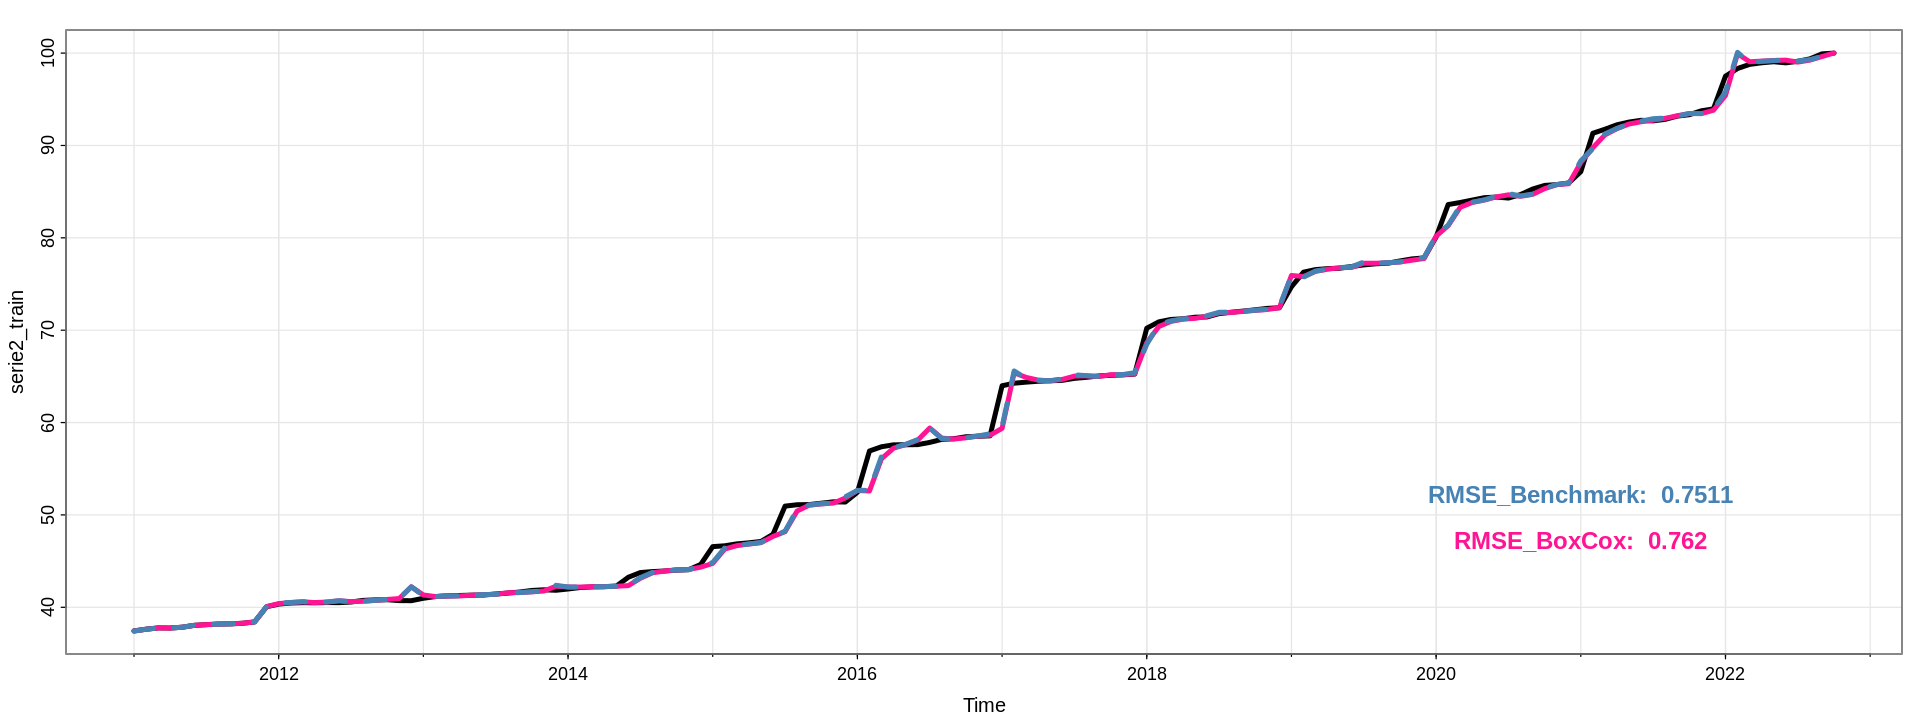

In [24]:
rmse_m2_train <- sd(InvBoxCox(fitted(fit), lambda=lam) - serie2_train)
tsplot(serie2_train, lwd=4)
lines(InvBoxCox(fitted(fit), lambda=lam), col="deeppink", lwd=4)
lines(vector_ajustes[[2]], col="steelblue", lwd=4, lty=2)
text(x=c(2021,2), y=50, paste("RMSE_Benchmark: ", round(rmse_train[[2]],4)),pos = 3, col = "steelblue", cex = 1.2, font = 2)
text(x=c(2021,2), y=45, paste("RMSE_BoxCox: ", round(rmse_m2_train,4)),pos = 3, col = "deeppink", cex = 1.2, font = 2)

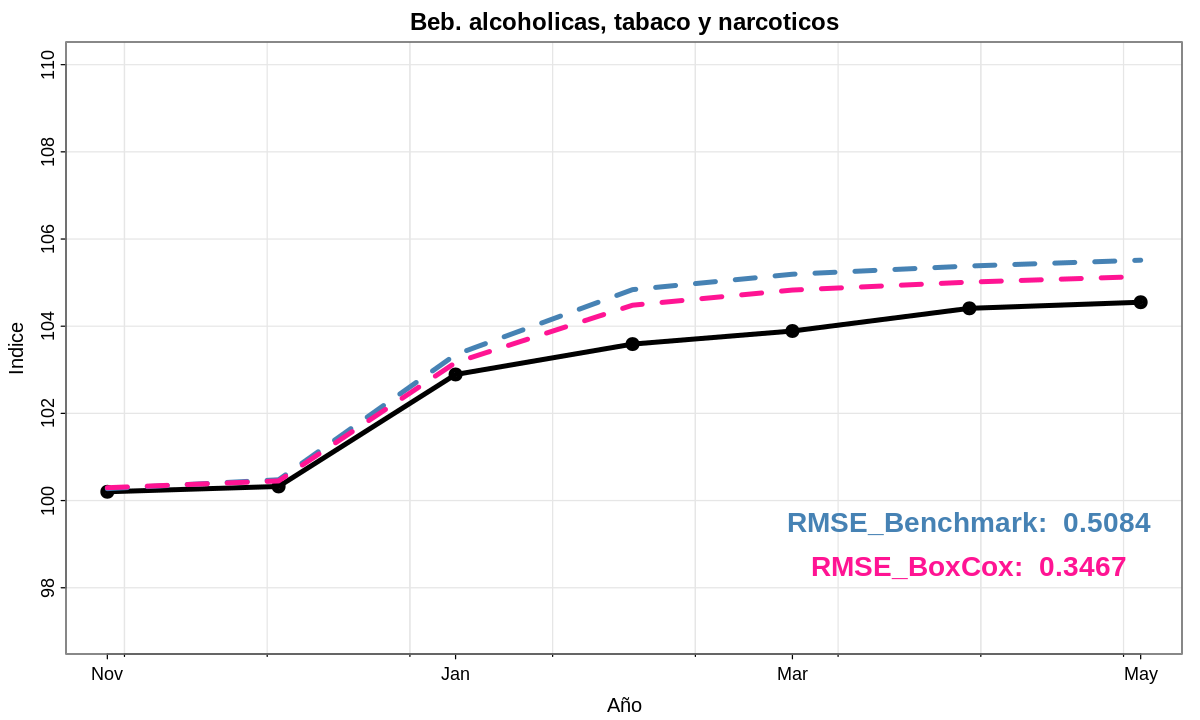

In [25]:
pred2 <- forecast(fit, h=7)
unt_pred2 <- InvBoxCox(pred2$mean, lambda=lam) # se revierte la transformación
options(repr.plot.width=10, repr.plot.height=6)
tsplot(x=dates, y=serie2_validation, col="black", lwd=4, ylim=c(97, 110),ylab="Indice", xlab="Año", main=nombres[[2]])
points(x=dates, y=serie2_validation, col="black", lwd=4)
lines(x=dates, y=vector_predicciones[[2]]$mean, col="steelblue", lty="dashed", lwd=4)
lines(x=dates, y=unt_pred2, col="deeppink", lty="dashed", lwd=4)
rmse_m2_val <- sd(unt_pred2 - serie2_validation)
text(x=dates[6], y=99, paste("RMSE_Benchmark: ", round(rmse_val[[2]],4)), pos = 3, col = "steelblue", cex = 1.4, font = 2)
text(x=dates[6], y=98, paste("RMSE_BoxCox: ", round(rmse_m2_val,4)), pos = 3, col = "deeppink", cex = 1.4, font = 2)

### 3.3 Vivienda, Agua, Electricidad, Gas y otros

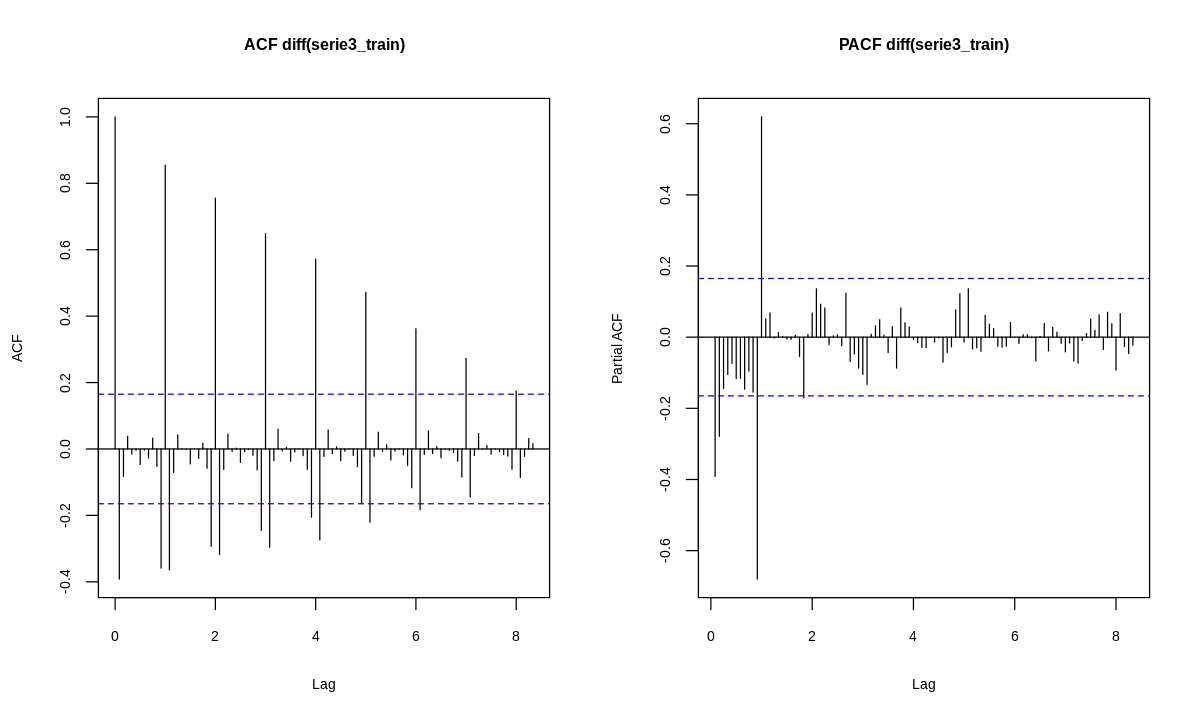

In [26]:
par(mfrow=c(1,2), cex.main=0.8, cex.lab=0.7, cex.axis=0.7)
acf(diff(serie3_train), main="ACF diff(serie3_train)", 100)
pacf(diff(serie3_train), main="PACF diff(serie3_train)", 100)

El lag1 de acf, los lag1-lag2 de pacf, asi como el lag1 estacional de pacf son significativos (en acf decaen exponencialmente). Se propone entonces un ARIMA(2,1,1)(1,1,0)

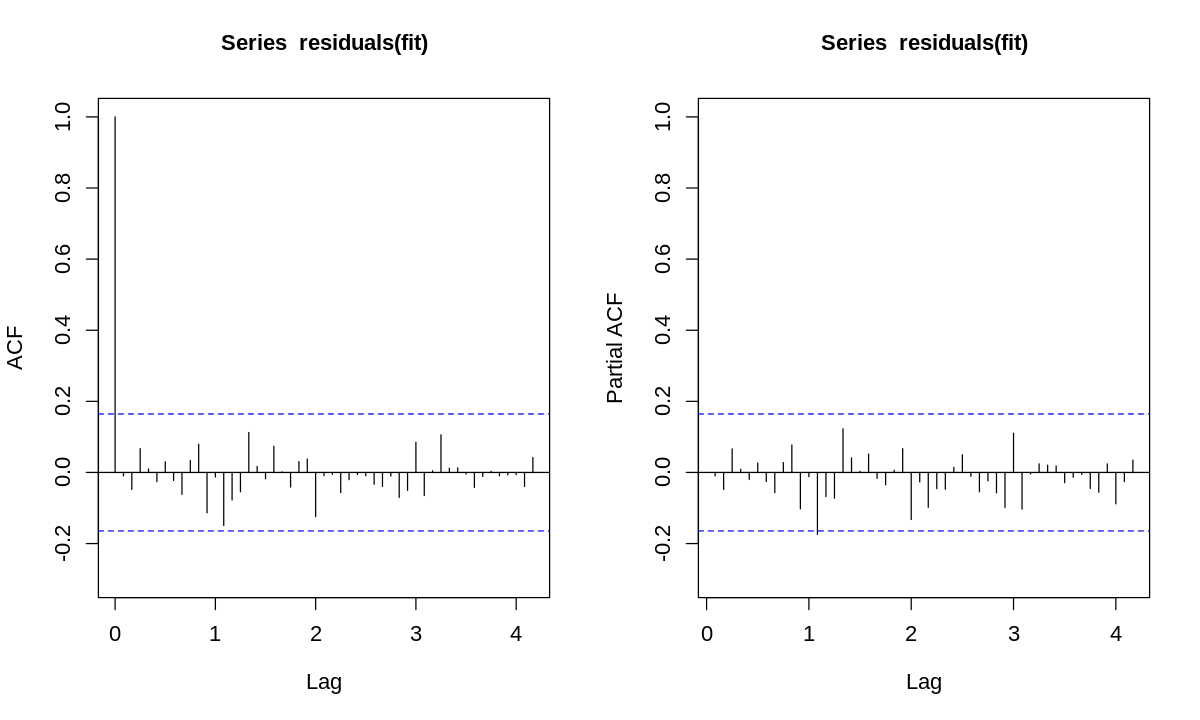

In [27]:
fit <- Arima(serie3_train, order=c(2,1,1), seasonal=c(1,1,0))
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
acf(residuals(fit), 50, ylim=c(-0.3,1))
pacf(residuals(fit), 50, ylim=c(-0.3,1))

Se acepta el modelo ya que los ruidos son blancos. Se procede a la predicción y comparación vs Benchmark

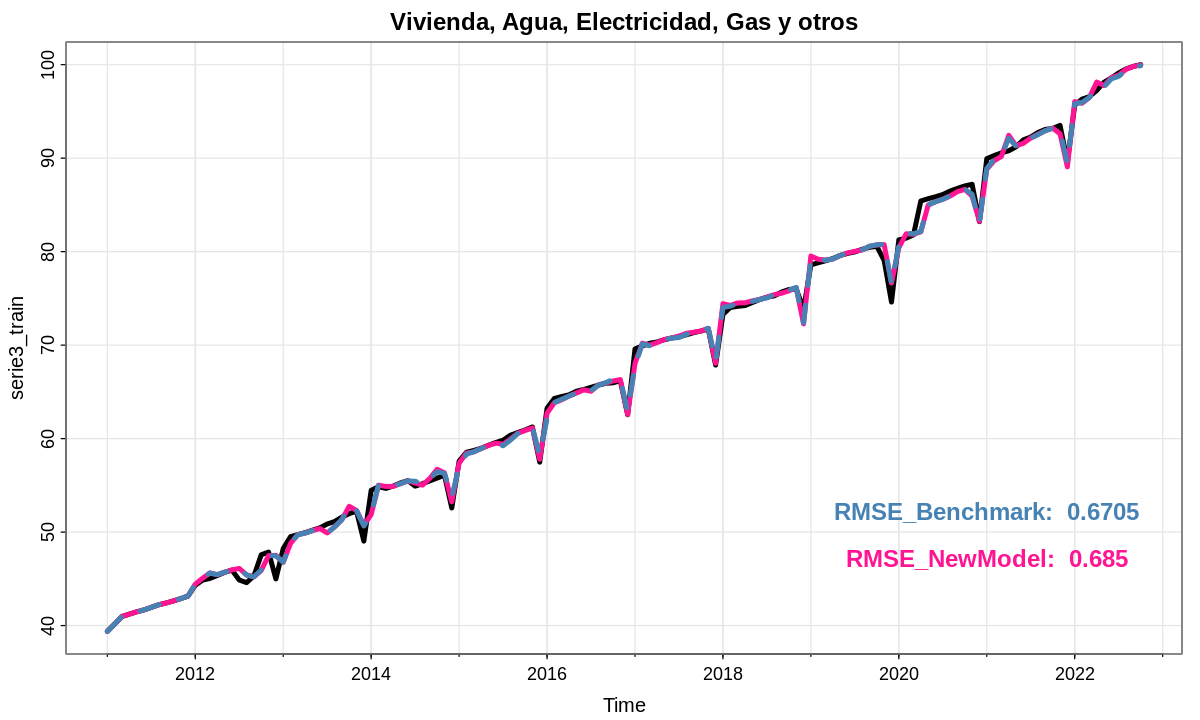

In [28]:
tsplot(serie3_train, main=nombres[[3]], col="black", lwd=4)
rmse_m3_train <- sd(fitted(fit) - serie3_train)
lines(fitted(fit), col="deeppink", lwd=4)
lines(vector_ajustes[[3]], col="steelblue", lwd=4, lty=2)
text(x=c(2021,2), y=50, paste("RMSE_Benchmark: ", round(rmse_train[[3]],4)),pos = 3, col = "steelblue", cex = 1.2, font = 2)
text(x=c(2021,2), y=45, paste("RMSE_NewModel: ", round(rmse_m3_train,4)),pos = 3, col = "deeppink", cex = 1.2, font = 2)

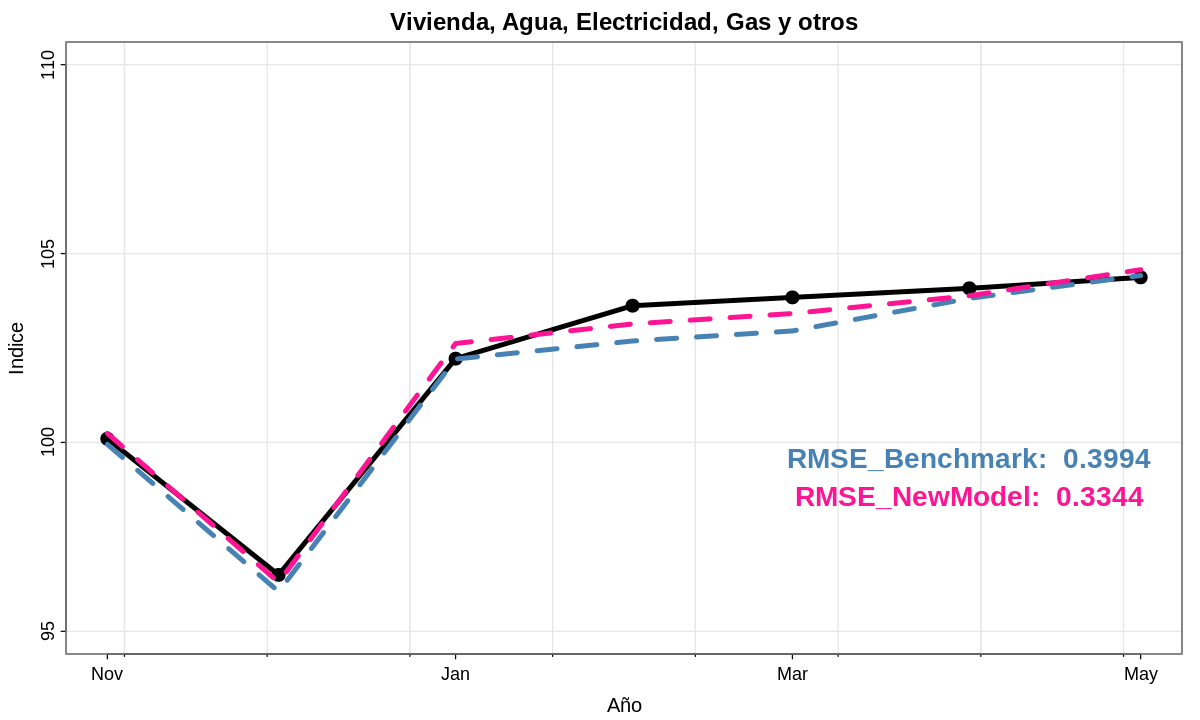

In [29]:
# PREDICCION
layout(1)
options(repr.plot.width=10, repr.plot.height=6)
pred3 <- forecast(fit, h=7)
tsplot(x=dates, y=serie3_validation, col="black", lwd=4, ylim=c(95, 110),ylab="Indice", xlab="Año", main=nombres[[3]])
points(x=dates, y=serie3_validation, col="black", lwd=4)
lines(x=dates, y=vector_predicciones[[3]]$mean, col="steelblue", lty="dashed", lwd=4)
lines(x=dates, y=pred3$mean, col="deeppink", lty="dashed", lwd=4)
rmse_m3_val <- sd(pred3$mean - serie3_validation)
text(x=dates[6], y=99, paste("RMSE_Benchmark: ", round(rmse_val[[3]],4)),pos = 3, col = "steelblue", cex = 1.4, font = 2)
text(x=dates[6], y=98, paste("RMSE_NewModel: ", round(rmse_m3_val,4)),pos = 3, col = "deeppink", cex = 1.4, font = 2)

#### Ajustes y Predicciones con Modelo de Espacio de Estados (libreria dlm)

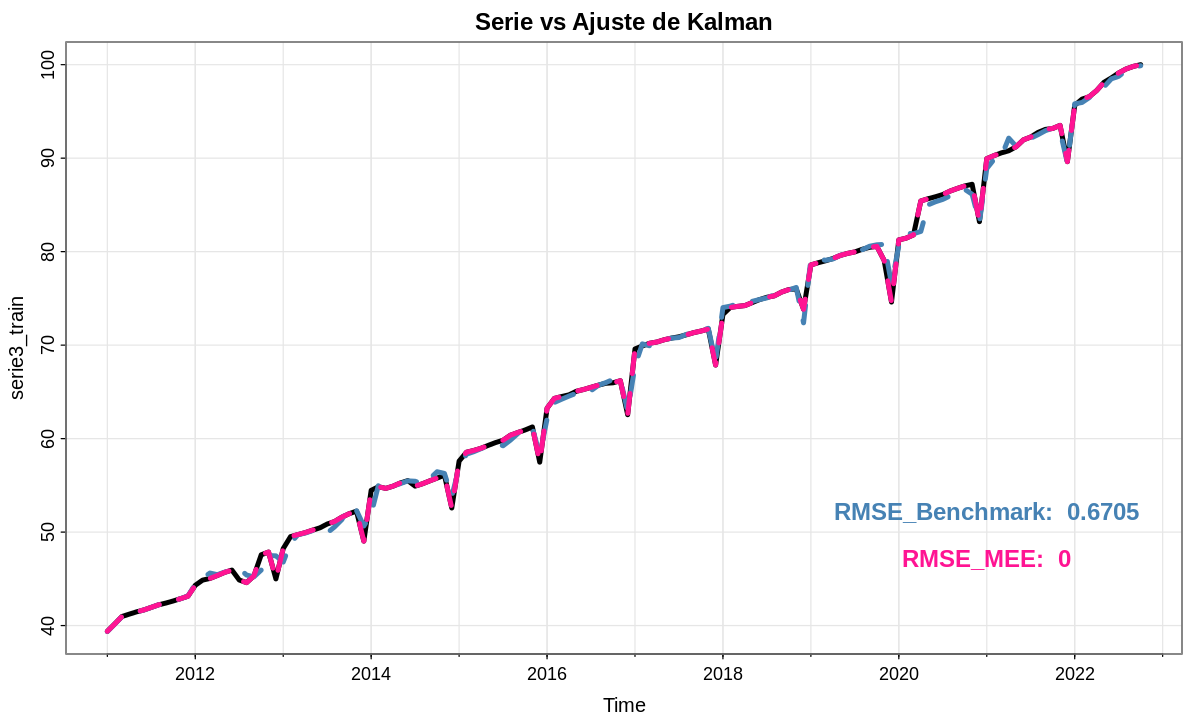

In [30]:
# Como la serie tiene marcada tendencia estacional, se ajusta un modelo que la contemple
fn <- function(parm) {
    mod <- dlmModPoly(order = 1) + dlmModSeas(frequency = 12)
    V(mod) <- exp(parm[1])
    diag(W(mod))[1:2] <- exp(parm[2:3])
    return(mod)
}

fit <- dlmMLE(serie3_train, rep(0, 3), build = fn, hessian = TRUE)
conv <- fit$convergence  # zero for converged

loglik <- dlmLL(serie3_train, dlmModPoly(1) + dlmModSeas(4))
n.coef <- 3
r.aic <- (2 * (loglik)) + 2 * (sum(n.coef))  #dlmLL caculates the neg. LL
r.bic <- (2 * (loglik)) + (log(length(serie3_train))) * (n.coef)

mod <- fn(fit$par)
obs.error.var <- V(mod)
state.error.var <- diag(W(mod))

filtered <- dlmFilter(serie3_train, mod = mod)
smoothed <- dlmSmooth(filtered)
resids <- residuals(filtered, sd = FALSE)
mu <- dropFirst(smoothed$s[, 1])
gammas <- dropFirst(smoothed$s[, 2])

mu.1 <- mu[1]
mu.end <- mu[length(mu)]
gammas.1 <- gammas[1]
gammas.end <- gammas[length(mu)]

alpha <- mu + gammas
rmse_mee_train <- sd(alpha - serie3_train)

tsplot(serie3_train, lwd=4, main="Serie vs Ajuste de Kalman")
lines(vector_ajustes[[3]], col="steelblue", lwd=4, lty=2)
lines(alpha, lwd=4, col="deeppink", lty="dashed")
text(x=c(2021,2), y=50, paste("RMSE_Benchmark: ", round(rmse_train[[3]],4)), pos = 3, col = "steelblue", cex = 1.2, font = 2)
text(x=c(2021,2), y=45, paste("RMSE_MEE: ", round(rmse_mee_train,4)), pos = 3, col = "deeppink", cex = 1.2, font = 2)

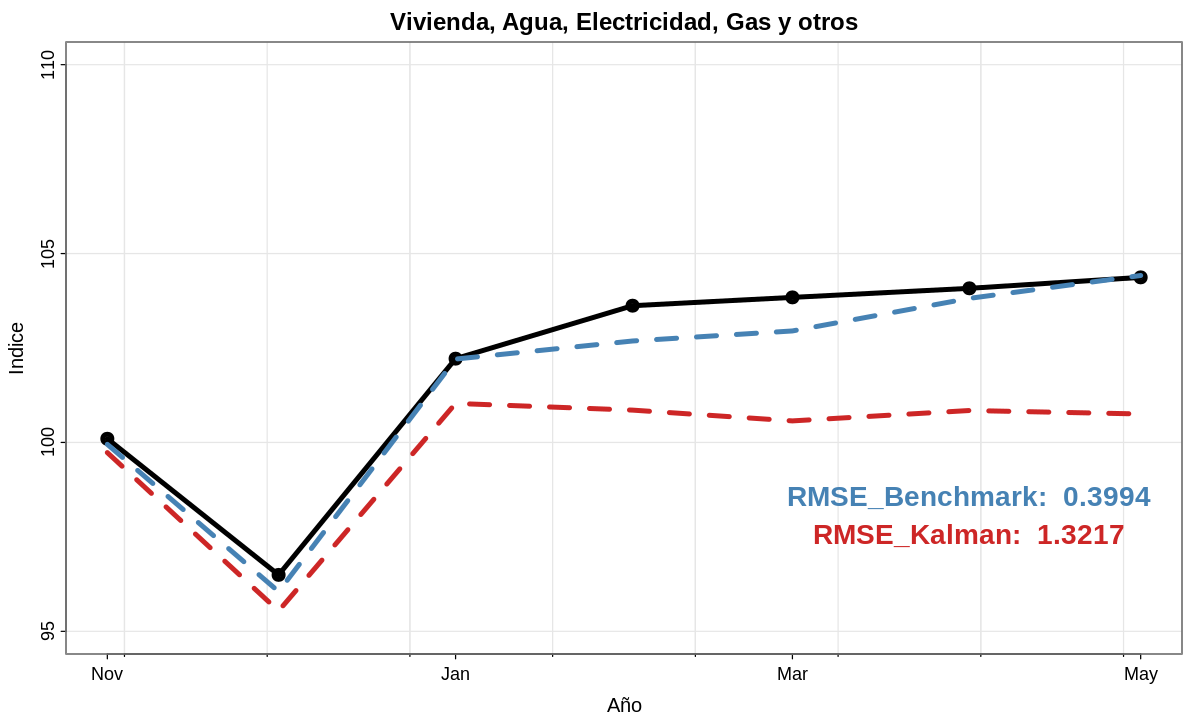

In [31]:
# PREDICCION
layout(1)
options(repr.plot.width=10, repr.plot.height=6)
forecast <- dlmForecast(filtered, nAhead = 7)
tsplot(x=dates, y=serie3_validation, col="black", lwd=4, ylim=c(95, 110),ylab="Indice", xlab="Año", main=nombres[[3]])
points(x=dates, y=serie3_validation, col="black", lwd=4)
lines(x=dates, y=vector_predicciones[[3]]$mean, col="steelblue", lty="dashed", lwd=4)
lines(x=dates, y=forecast$f, col="firebrick3", lty="dashed", lwd=4)
rmse_mee_val <- sd(forecast$f - serie3_validation)
text(x=dates[6], y=98, paste("RMSE_Benchmark: ", round(rmse_val[[3]],4)),pos = 3, col = "steelblue", cex = 1.4, font = 2)
text(x=dates[6], y=97, paste("RMSE_Kalman: ", round(rmse_mee_val,4)),pos = 3, col = "firebrick3", cex = 1.4, font = 2)

Notorio overfitting del modelo de espacio de estados

### 3.4 Información y Comunicaciòn

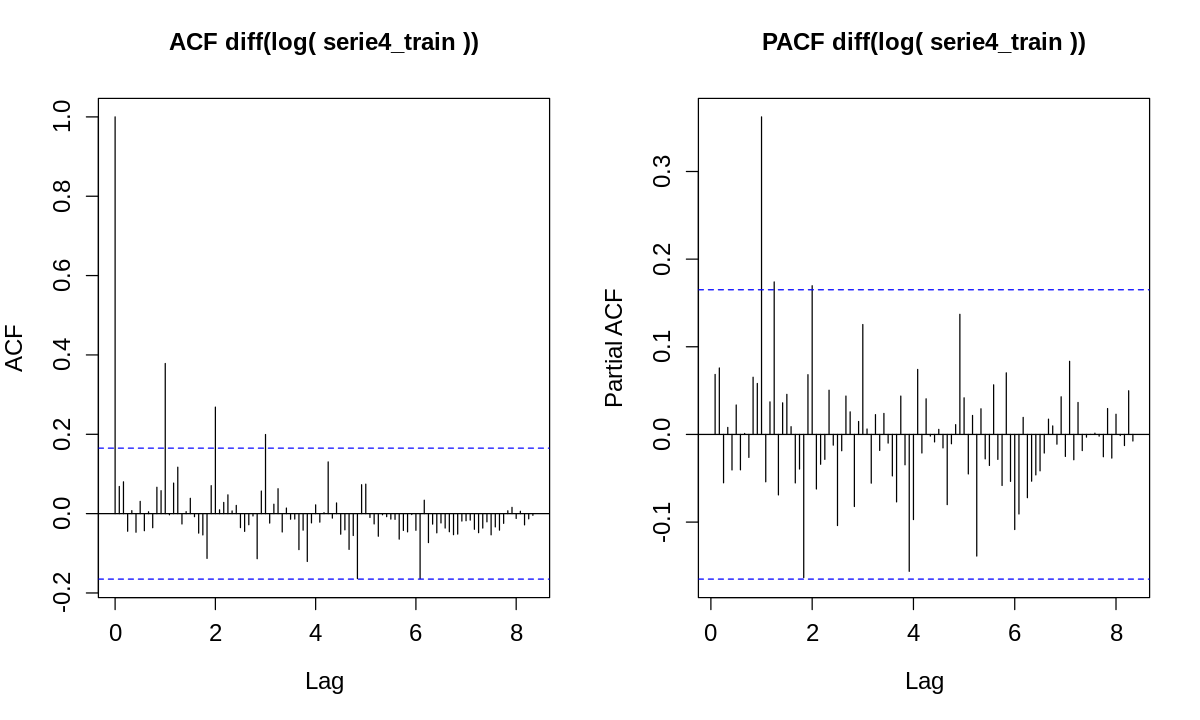

In [32]:
par(mfrow=c(1,2), cex.main=1.2, cex.lab=1.2, cex.axis=1.2)
acf(diff(log(serie4_train)), main="ACF diff(log( serie4_train ))", 100)
pacf(diff(log(serie4_train)), main="PACF diff(log( serie4_train ))", 100)

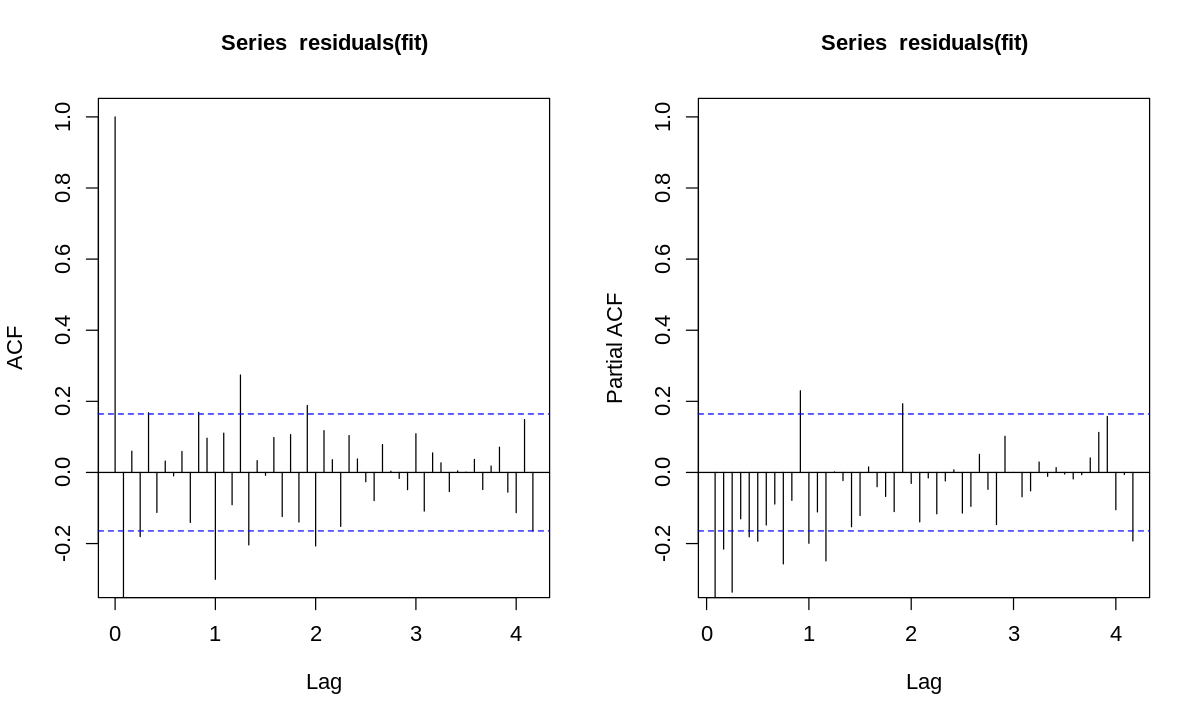

In [33]:
fit <- Arima(serie4_train, order=c(0,2,0), seasonal=c(1,2,0))
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
acf(residuals(fit), 50, ylim=c(-0.3,1))
pacf(residuals(fit), 50, ylim=c(-0.3,1))

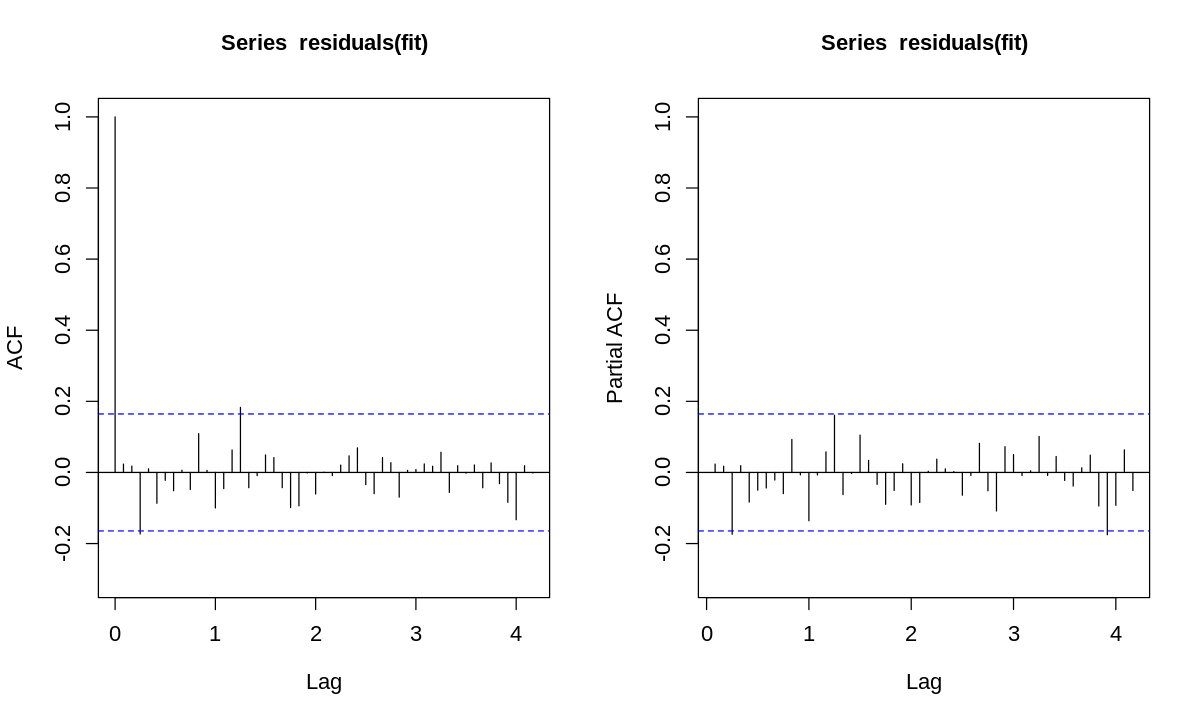

In [34]:
fit <- Arima(serie4_train, order=c(0,2,1), seasonal=c(1,2,2))
par(mfrow=c(1,2), cex.main=1.1, cex.lab=1.1, cex.axis=1.1)
acf(residuals(fit), 50, ylim=c(-0.3,1))
pacf(residuals(fit), 50, ylim=c(-0.3,1))

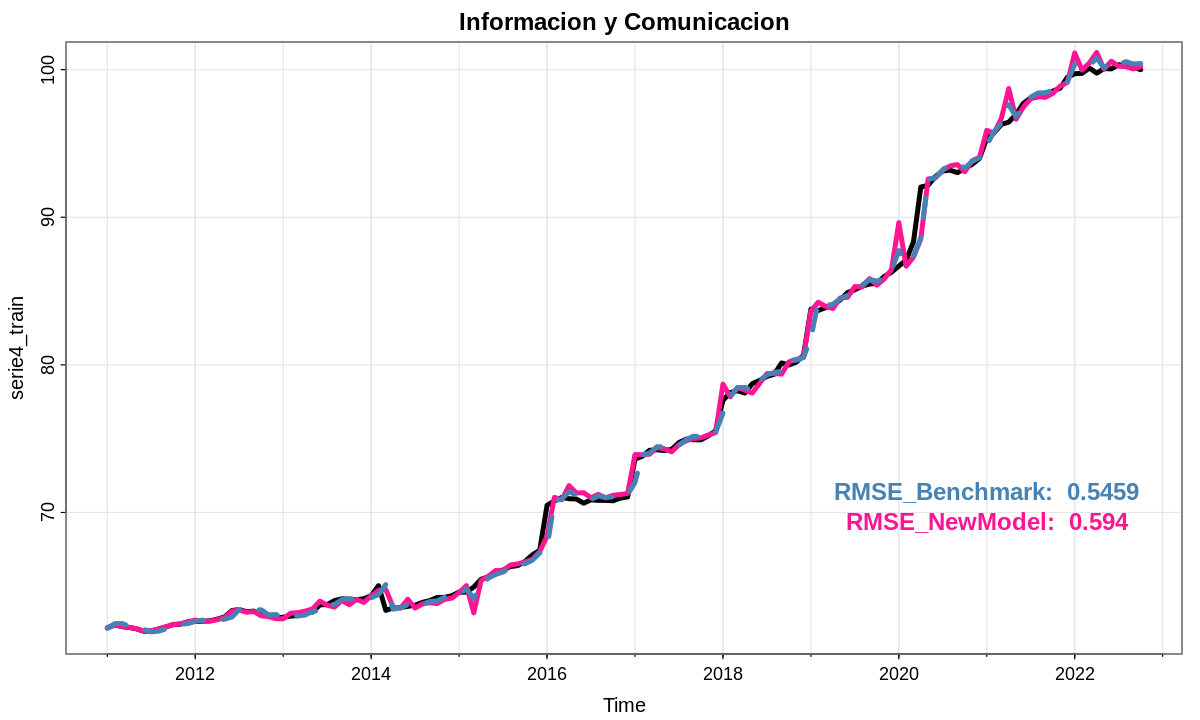

In [35]:
tsplot(serie4_train, main=nombres[[4]], col="black", lwd=4)
rmse_m4_train <- sd(fitted(fit) - serie4_train)
lines(fitted(fit), col="deeppink", lwd=4)
lines(vector_ajustes[[4]], col="steelblue", lwd=4, lty=2)
text(x=c(2021,2), y=70, paste("RMSE_Benchmark: ", round(rmse_train[[4]],4)), pos = 3, col = "steelblue", cex = 1.2, font = 2)
text(x=c(2021,2), y=68, paste("RMSE_NewModel: ", round(rmse_m4_train,4)), pos = 3, col = "deeppink", cex = 1.2, font = 2)

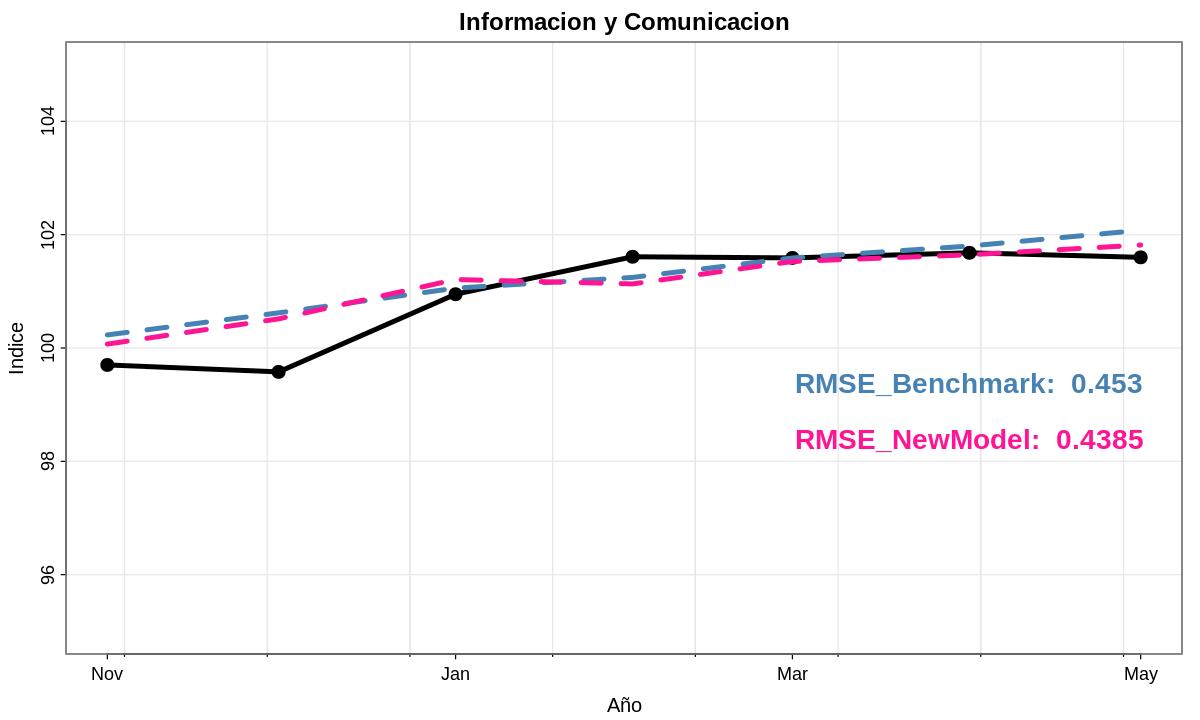

In [36]:
# PREDICCION
layout(1)
options(repr.plot.width=10, repr.plot.height=6)
pred4 <- forecast(fit, h=7)
tsplot(x=dates, y=serie4_validation, col="black", lwd=4, ylim=c(95, 105),ylab="Indice", xlab="Año", main=nombres[[4]])
points(x=dates, y=serie4_validation, col="black", lwd=4)
lines(x=dates, y=vector_predicciones[[4]]$mean, col="steelblue", lty="dashed", lwd=4)
lines(x=dates, y=pred4$mean, col="deeppink", lty="dashed", lwd=4)
rmse_m4_val <- sd(pred4$mean - serie4_validation)
text(x=dates[6], y=99, paste("RMSE_Benchmark: ", round(rmse_val[[4]],4)), pos=3, col = "steelblue", cex = 1.4, font = 2)
text(x=dates[6], y=98, paste("RMSE_NewModel: ", round(rmse_m4_val,4)), pos=3, col = "deeppink", cex = 1.4, font = 2)

#### Ajustes y Prediccion con LSTM

In [37]:
serie4_train <- ts(diff(serie4), start=2011 + (1/12), end=2022 + (9/12), frequency=12)
serie4_validation <- tail(diff(serie4), 10)

Genero los grupos tensores de Train y Validation

In [38]:
window <- 3 # ventana de entrenamiento
pred <- 1 # periodos a predecir
n <- length(serie4_train)

x_train <- matrix(0, nrow=n-window, ncol=window) # matriz de 0s 
y_train <- matrix(0, nrow=n-window, ncol=pred)
for (i in 1:(n-window-pred+1)){
  x_train[i,] <- serie4_train[i:(i+window-1)] # de 1a3, de 2a4, de 3a5, ... 
  y_train[i,] <- serie4_train[(i+window):(i+window+pred-1)] # 4, 5, 6, ...
}
x_train <- array(data = x_train, dim = c(n-window-pred+1, window, 1))

n <- length(serie4_validation)
x_val <- matrix(0, nrow=n-window, ncol=window) # matriz de 0s 
y_val <- matrix(0, nrow=n-window, ncol=pred)
for (i in 1:(n-window-pred+1)){
  x_val[i,] <- serie4_validation[i:(i+window-1)] 
  y_val[i,] <- serie4_validation[(i+window):(i+window+pred-1)] 
}
x_val <- array(data = x_val, dim = c(n-window-pred+1, window, 1))

Model: "sequential"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_2 (Dense)                     (None, 3, 8)                    16          
________________________________________________________________________________
dropout_2 (Dropout)                 (None, 3, 8)                    0           
________________________________________________________________________________
lstm (LSTM)                         (None, 4)                       208         
________________________________________________________________________________
dropout_1 (Dropout)                 (None, 4)                       0           
________________________________________________________________________________
dense_1 (Dense)                     (None, 2)                       10          
________________________________________________________________________________
dropout 

loss       mse 
0.3556209 0.3556209

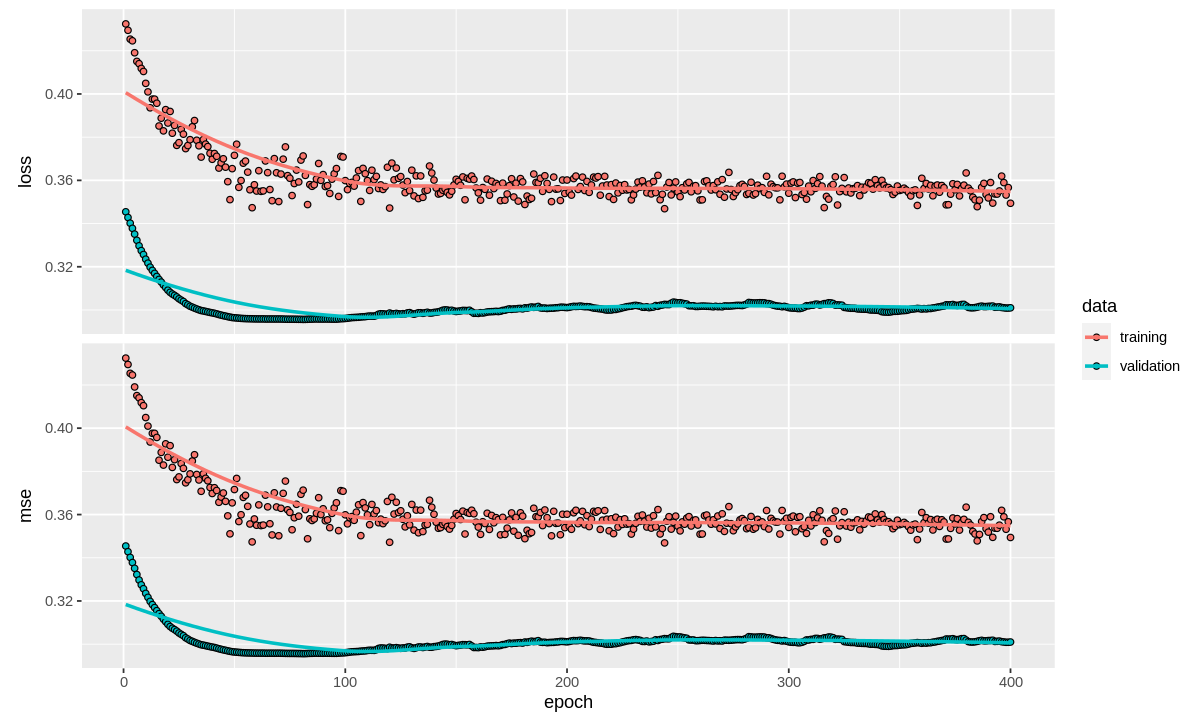

In [39]:
# LSTM
model_lstm <- keras_model_sequential()
model_lstm %>%
    layer_dense(input_shape=dim(x_train)[2:3], units=8, activation="relu") %>%
    layer_dropout(0.5) %>%
    layer_lstm(units=4, activation="relu") %>%
    layer_dropout(0.5) %>%
    layer_dense(units=2, activation="relu") %>%
    layer_dropout(0.5) %>%
    layer_dense(units=1)
summary(model_lstm)
model_lstm %>% compile(loss="mse",
                   optimizer="nadam",
                   metrics=c("mse"))
trained_model_lstm <- model_lstm %>% fit(
  x = x_train,
  y = y_train,
  epochs = 400,
  validation_data = list(x_val, y_val)
)
plot(trained_model_lstm)
evaluate(model_lstm, x_train, y_train)

In [40]:
##### PREDICCION SOBRE VALIDATION

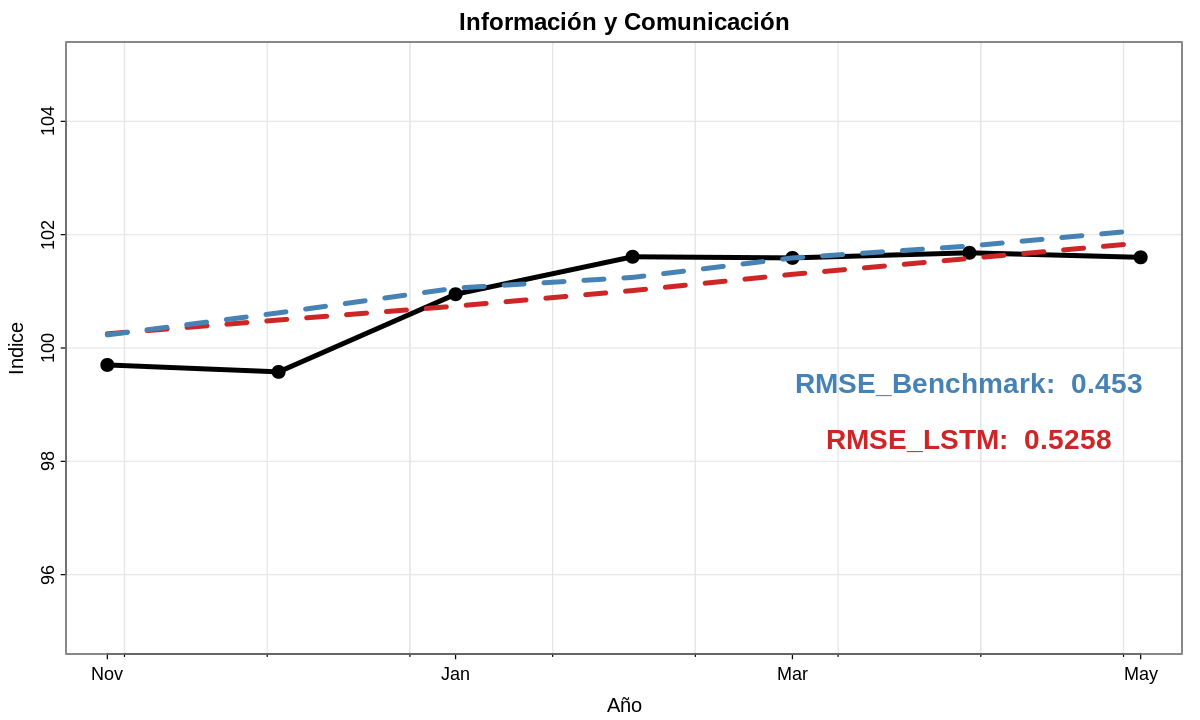

In [41]:
fore <- predict(model_lstm, x_val)
pred_level <- ts(100 + cumsum(fore), start=2022+(10/12), frequency=12)
options(repr.plot.width=10, repr.plot.height=6)
tsplot(x=dates, y=tail(serie4, 7), ylim=c(95, 105), lwd=4, main="Información y Comunicación", ylab="Indice", xlab="Año")
points(x=dates, y=tail(serie4, 7), lwd=4, pch=19)
lines(x=dates, y=pred_level, lwd=4, col="firebrick3", lty="dashed")
lines(x=dates, y=vector_predicciones[[4]]$mean, col="steelblue", lty="dashed", lwd=4)
rmse_lstm <- sd(pred_level - tail(serie4, 7))

text(x=dates[6], y=99, paste("RMSE_Benchmark: ", round(rmse_val[[4]],4)),pos = 3, col = "steelblue", cex = 1.4, font = 2)
text(x=dates[6], y=98, paste("RMSE_LSTM: ", round(rmse_lstm,4)), pos=3, col = "firebrick3", cex = 1.4, font = 2)

#### LSTM + EarlyStopping + ModelCheckpoint

loss       mse 
0.3583991 0.3583991

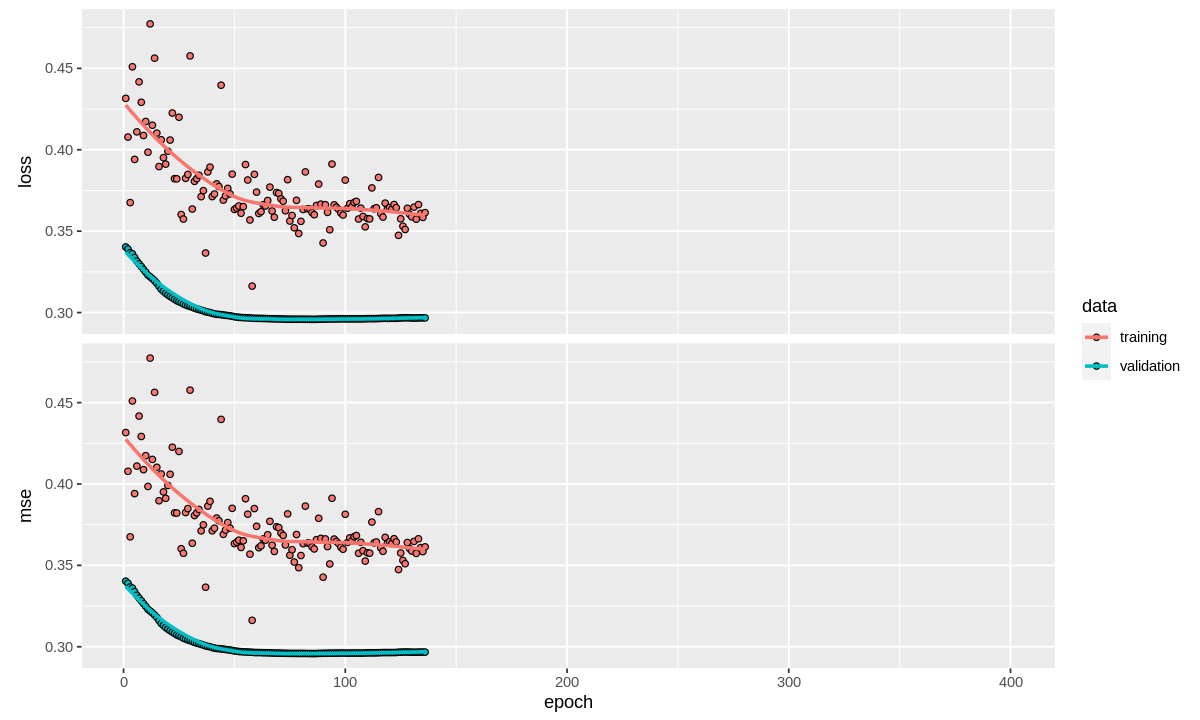

In [42]:
# LSTM
model <- keras_model_sequential()
model %>%
    layer_dense(input_shape=dim(x_train)[2:3], units=16, activation="relu") %>%
    layer_dropout(0.8) %>%
    layer_lstm(units=8, activation="relu") %>%
    layer_dropout(0.8) %>%
    layer_dense(units=4, activation="relu") %>%
    layer_dropout(0.8) %>%
    layer_dense(units=1)

checkpoint <- callback_model_checkpoint(
    filepath = "best_model.h5", 
    monitor = "val_loss",     
    save_best_only = TRUE       
)

early_stopping <- callback_early_stopping(
    monitor = "val_loss", 
    patience = 50          
)

model %>% compile(
    optimizer = "nadam",
    loss = "mse",
    metrics = c("mse")
)

history <- model %>% fit(
    x_train, 
    y_train,
    epochs = 400,
    validation_data = list(x_val, y_val),
    callbacks = list(checkpoint, early_stopping)
)

plot(history)
evaluate(model, x_train, y_train)

In [43]:
##### Predicciones sobre validation

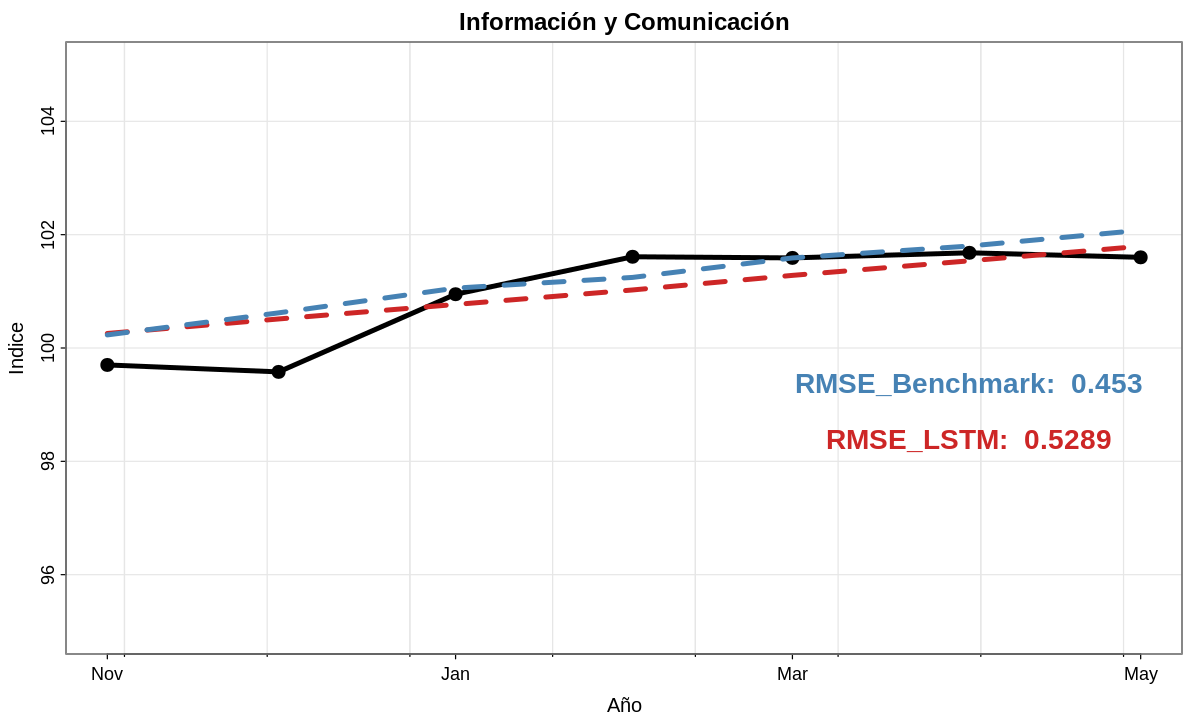

In [44]:
fore <- predict(model, x_val)
pred_level <- ts(100 + cumsum(fore), start=2022+(10/12), frequency=12)
options(repr.plot.width=10, repr.plot.height=6)
tsplot(x=dates, y=tail(serie4, 7), ylim=c(95, 105), lwd=4, main="Información y Comunicación", ylab="Indice", xlab="Año")
points(x=dates, y=tail(serie4, 7), lwd=4, pch=19)
lines(x=dates, y=pred_level, lwd=4, col="firebrick3", lty="dashed")
lines(x=dates, y=vector_predicciones[[4]]$mean, col="steelblue", lty="dashed", lwd=4)
rmse_lstm <- sd(pred_level - tail(serie4, 7))

text(x=dates[6], y=99, paste("RMSE_Benchmark: ", round(rmse_val[[4]],4)),pos = 3, col = "steelblue", cex = 1.4, font = 2)
text(x=dates[6], y=98, paste("RMSE_LSTM: ", round(rmse_lstm,4)), pos=3, col = "firebrick3", cex = 1.4, font = 2)